In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import joblib
    
    
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [3]:
state = 'AL'

file_symptoms = 'comments/raw_comments/agent_comments_'+state+\
                        '_filtered_final_symptoms_df_expanded.fea'
symptoms_dataframe_ri = pd.read_feather(file_symptoms)


In [4]:
symptoms_dataframe_ri['transaction_year'] = np.floor(np.array((symptoms_dataframe_ri['Transdate'].values/10000)))

In [5]:
symptoms_dataframe_ri = symptoms_dataframe_ri.dropna()

In [6]:
symptoms_df = symptoms_dataframe_ri.iloc[:,17:]

In [7]:
symptoms_df['cj_living_area'] = symptoms_dataframe_ri['cj_living_area']
symptoms_df['avmValue'] = symptoms_dataframe_ri['avmValue']
symptoms_df['transaction_year'] = symptoms_dataframe_ri['transaction_year'] 

In [8]:
predictor_columns = symptoms_df.columns

In [9]:
symptoms_df = symptoms_df.loc[:,predictor_columns]

In [10]:
Predictors = symptoms_df.to_numpy()

In [11]:
predictand = symptoms_dataframe_ri.avmerror.values

In [12]:
nclasses = 3
discretizer = KBinsDiscretizer(n_bins=nclasses, encode='ordinal', strategy='quantile')

In [13]:
Series = predictand
discretizer.fit(Series.reshape(-1,1))
Series_disctzd = discretizer.transform(Series.reshape(-1,1))

In [14]:
Series_disctzd = Series_disctzd.reshape(len(Series_disctzd))

In [15]:
train_samples = 150000  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    Predictors,
    Series_disctzd,
    shuffle=False,
    test_size=len(Predictors) - train_samples,
)

## First Stage: Classification

In [18]:
models = ['RF_class_firstStage.sav']

In [26]:
for model_file in models:
    print(model_file)

    model = joblib.load(model_file)
    
    predictions_test = model.predict(X_test)
    predictions_test_prob = model.predict_proba(X_test)
    
    print(accuracy_score(y_test, predictions_test))
    print(top_k_accuracy_score(y_test, predictions_test_prob, k=2))
    
    

RF_class_firstStage.sav
0.4840653526784914
0.7751215050485123


In [41]:
X_test.shape

(55759, 2388)

In [45]:
models_secondStage_file = ['RF_class_secondStage_0_.sav',
                          'RF_class_secondStage_1_.sav',
                          'RF_class_secondStage_2_.sav']

models_secondStage = []

for model_file in models_secondStage_file:
    print(model_file)
    models_secondStage.append(joblib.load(model_file))

    


RF_class_secondStage_0_.sav
RF_class_secondStage_1_.sav
RF_class_secondStage_2_.sav


In [47]:
models_secondStage

[RandomForestRegressor(max_depth=50, max_features=150, min_samples_leaf=20),
 RandomForestRegressor(max_depth=50, max_features=150, min_samples_leaf=20),
 RandomForestRegressor(max_depth=50, max_features=150, min_samples_leaf=20)]

In [74]:
pred_1 = models_secondStage[0].predict(X_test)
pred_2 = models_secondStage[1].predict(X_test)
pred_3 = models_secondStage[2].predict(X_test)

In [77]:
pred_3

array([0.19296419, 0.17728374, 0.18276076, ..., 0.15004515, 0.15276536,
       0.17380963])

In [76]:
pred_2

array([0.01589743, 0.01675788, 0.0127318 , ..., 0.01885292, 0.02034546,
       0.02111995])

In [75]:
pred_1

array([-0.19680385, -0.18701186, -0.16969986, ..., -0.20424819,
       -0.26284945, -0.24380418])

In [88]:
predictions_test_prob[4,:]

array([0.39205388, 0.30685043, 0.30109569])

In [89]:
y_test[4]

0.0

In [91]:
df['avmerror'].values[train_samples:][0]

-0.1654438056680161

In [92]:
avmValue_test[0]

287864.62

In [93]:
df['Transprice'].values[train_samples:][0]

247000.0

In [97]:
avmValue_test[0]/(1-(-0.1654438056680161))

247000.00000000003

In [98]:
pred_1[0]

-0.19680385312885287

In [99]:
avmValue_test[0]/(1-(-0.19680385312885287))

240527.81852884564

In [101]:
all_preds = np.zeros([3,len(predictions_test)])

In [102]:
all_preds.shape

(3, 55759)

In [104]:
all_preds[0,:] = pred_1
all_preds[1,:] = pred_2
all_preds[2,:] = pred_3

In [131]:
y_test

array([0., 1., 1., ..., 2., 0., 2.])

In [171]:
predictions_test_secondStage = np.zeros(len(predictions_test))

for i in range(len(predictions_test)):
    print(i)
    positions = np.argsort(predictions_test_prob[i,:])[::-1] 
    #print(positions)
    print(predictions_test_prob[i,positions[0]]-predictions_test_prob[i,positions[1]])
    if (predictions_test_prob[i,positions[0]]-predictions_test_prob[i,positions[1]]) > 0.135:
        #predictions_test_secondStage[i] = all_preds[positions[0],i]
        predictions_test_secondStage[i] = all_preds[int(y_test[i]),i]
    else:
        predictions_test_secondStage[i] = 0.
        
    #scale_rw = predictions_test_prob[i,positions[0:2]].sum()
    #pred_final = (pred_1 * predictions_test_prob[i,positions[0]] 
    #              + pred_2 * predictions_test_prob[i,positions[1]]) / scale_rw
    #predictions_test_secondStage[i] = pred_final
    #predictions_test_secondStage_first[i] = pred_1
    #predictions_test_secondStage_second[i] = pred_2

0
0.16582819667204352
1
0.013149606114061407
2
0.09305084847218231
3
0.09337170731332867
4
0.08520344999602936
5
0.03530904232067733
6
0.06695286659098715
7
0.024121925881643747
8
0.00622149511354847
9
0.06904668944784376
10
0.2185453017696365
11
0.06309175844199288
12
0.2512788852346038
13
0.21396810844571762
14
0.04603186014467048
15
0.04284580107375907
16
0.017592262660127922
17
0.10397845034256353
18
0.04100272513255204
19
0.07110583546578464
20
0.030170724399938065
21
0.006108581769257215
22
0.0642555586393237
23
0.0031761227953923665
24
0.04541071058224533
25
0.008928504021477046
26
0.11555925312725368
27
0.059902269631873895
28
0.11288346468712168
29
0.1283293318900447
30
0.13708288905066895
31
0.0805503096965135
32
0.11461838593812973
33
0.21175926889792596
34
0.1101407155827242
35
0.026800250476971932
36
0.06096763755776796
37
0.04148444300268683
38
0.17014734343014942
39
0.03621907708858357
40
0.058640713538667066
41
0.055120541410655366
42
0.1442614828543699
43
0.02343216424

0.04171266492629472
470
0.06535600192455482
471
0.03215338086830066
472
0.12387544357532587
473
0.005052328758757663
474
0.00465717475000077
475
0.11890685131260176
476
0.029568190008690876
477
0.03208583074298832
478
0.17158473768239768
479
0.11852468012907491
480
0.025299098127462116
481
0.16258831118960393
482
0.06683444869106003
483
0.04959809283754296
484
0.1488381848985188
485
0.10567178583845394
486
0.1296740635733043
487
0.04112811330416288
488
0.07388066558315909
489
0.1490398191106242
490
0.03284862908490016
491
0.03979183455146157
492
0.035991833971523
493
0.06771242820153334
494
0.04993089479079299
495
0.020022134213762866
496
0.30572181420634836
497
0.35681817677480554
498
0.10388589651916591
499
0.07641267606285879
500
0.021011096623613112
501
0.05807954621030903
502
0.06649110682427078
503
0.36271662704002633
504
0.04167186361871805
505
0.017773130868118492
506
0.2229937952869489
507
0.16292650594084396
508
0.002350142964309687
509
0.07438824883441891
510
0.0787674285019

0.024811511813211062
984
0.03717958964164292
985
0.03867183726909906
986
0.011547908283872421
987
0.05531479240739806
988
0.07502874332922765
989
0.009327595452401305
990
0.1067939261285546
991
0.015708268978149253
992
0.05943564725156014
993
0.05389901400716368
994
0.06817159785979315
995
0.05402702956927552
996
0.040675407907251604
997
0.017231316568850963
998
0.2645244629496751
999
0.0910936044703044
1000
0.03201556911392378
1001
0.018077578120730575
1002
0.10970901788833304
1003
0.11312948010409962
1004
0.11354407366710101
1005
0.0969298015029853
1006
0.2498709027917777
1007
0.08727999831580846
1008
0.08167729958087688
1009
0.16584526366870833
1010
0.05300604912485679
1011
0.10738419391338405
1012
0.09177432022393328
1013
0.0955538046102754
1014
0.11960731373550543
1015
0.0394077177778151
1016
0.022666133228453733
1017
0.17845786710120753
1018
0.058609169048771004
1019
0.01680433276913601
1020
0.14425064242965802
1021
0.07500514397317665
1022
0.08212716218878763
1023
0.017234443398

0.12554740307120116
1525
0.06604177687166113
1526
0.0825474220243454
1527
0.166434985100413
1528
0.1180131325575266
1529
0.14485323635187308
1530
0.010535960162520952
1531
0.08133707189738937
1532
0.06052509883773877
1533
0.18492506511890394
1534
0.16813061994731648
1535
0.08756505035622708
1536
0.04392679403465255
1537
0.1353383162904549
1538
0.04722328731586095
1539
0.04345188481071338
1540
0.022359259009137045
1541
0.5638211960115964
1542
0.4327534217844416
1543
0.10975134953318383
1544
0.007272682187740631
1545
0.04887681425113982
1546
0.12264848023895336
1547
0.01909410723931676
1548
0.015242297937294258
1549
0.028285328028552992
1550
0.001569289746549074
1551
0.08102268732667167
1552
0.0702525936986067
1553
0.13570098625823462
1554
0.09380641818234081
1555
0.06008070148366984
1556
0.09311891481066037
1557
0.04565436871137085
1558
0.14507369040218027
1559
0.04566777603644734
1560
0.0547269762448524
1561
0.008925224668384746
1562
0.11830961600769258
1563
0.010303947823366466
1564
0

0.04960369630662825
2057
0.015531355895727017
2058
0.10360172765642378
2059
0.06873094777780281
2060
0.0190830491781821
2061
0.0017508117131494472
2062
0.14135636762248777
2063
0.006189723668769631
2064
0.04473816387606305
2065
0.35074711473091036
2066
0.02449930263361444
2067
0.12132185731065481
2068
0.16252147914931497
2069
0.0021489082885733923
2070
0.18475007085533474
2071
0.13009126296527784
2072
0.05918202849488724
2073
0.09106991217595123
2074
0.1333127869190749
2075
0.03467671230665792
2076
0.049590374198042686
2077
0.37116593971270007
2078
0.07857733753042512
2079
0.2009279552623946
2080
0.13000994187639647
2081
0.35197697020586804
2082
0.04685521427604322
2083
0.05369720708447212
2084
0.0437949861244909
2085
0.11603808124732073
2086
0.05742632754089266
2087
0.01096101761844348
2088
0.16084948297599616
2089
0.07810327751578039
2090
0.1850746334698707
2091
0.10925728364739085
2092
0.0992592861343205
2093
0.0831663748958581
2094
0.023759185659896376
2095
0.03194307142220443
2096

2596
0.023182056607620904
2597
0.06830586822676987
2598
0.0269061861116488
2599
0.010187229342043302
2600
0.002672106065135127
2601
0.010589927246686559
2602
0.00034004404232645946
2603
0.048900816364363
2604
0.01090448163308555
2605
0.012359067894595177
2606
0.0564255022849568
2607
0.08916832948546033
2608
0.12753609693065593
2609
0.08744463241336775
2610
0.055570778636178264
2611
0.09431298871550214
2612
0.023721532416854152
2613
0.03385384458082996
2614
0.03775415281322636
2615
0.013192391029853534
2616
0.05203186037835866
2617
0.060790225555159116
2618
0.020450060315986895
2619
0.13300937699015353
2620
0.03648163771929769
2621
0.11079429894425508
2622
0.07029143931033055
2623
0.11310842186221698
2624
0.057648348919773496
2625
0.06776360819535043
2626
0.16820223511009452
2627
0.03326065445576931
2628
0.046250573999390476
2629
0.1522434073615922
2630
0.017907340034801877
2631
0.007130765409866513
2632
0.17468070488597454
2633
0.06056332506928358
2634
0.03334944421832803
2635
0.033648

0.026547508792448327
3131
0.07283681156565741
3132
0.12262508279978573
3133
0.1717017044954285
3134
0.042857427412992755
3135
0.06778889763739815
3136
0.04355014213900521
3137
0.21866015005612877
3138
0.0524626511046794
3139
0.02070131714663792
3140
0.18715284881915933
3141
0.1621040474651506
3142
0.21241021137994048
3143
0.08936964282244142
3144
0.142329143579086
3145
0.03890400382837467
3146
0.18184735300241311
3147
0.18862912330578913
3148
0.029277703414073486
3149
0.004006595292299797
3150
0.0008812691170925202
3151
0.004317025342003067
3152
0.08072771787759153
3153
0.10494678269423324
3154
0.17076105119041946
3155
0.03458722901844791
3156
0.012986853063508663
3157
0.07339338528214084
3158
0.07735816744821783
3159
0.07180248028760217
3160
0.06145321665725967
3161
0.44499524184055556
3162
0.02481823692023677
3163
0.4096740420937397
3164
0.016907440694537923
3165
0.1394993188582639
3166
0.18469423908449212
3167
0.04863616573036744
3168
0.11693859784523786
3169
0.13279206491222745
317

3711
0.392736758798077
3712
0.042656558642201914
3713
0.12384330707284902
3714
0.038281209886524725
3715
0.008257781296630684
3716
0.10621934195677407
3717
0.0861558070850123
3718
0.044387480221318165
3719
0.05694289588175272
3720
0.04490809970243681
3721
0.0690592468292206
3722
0.031841875368829875
3723
0.00698392031901629
3724
0.0436046400823068
3725
0.0923920596381595
3726
0.0563634037063499
3727
0.0182454923660334
3728
0.020044124067995828
3729
0.004156767959025809
3730
0.13583044266387478
3731
0.038367698060069844
3732
0.20842416091224059
3733
0.03156708046589146
3734
0.08944663463897184
3735
0.07453893794630218
3736
0.40370858912165
3737
0.2081925541794148
3738
0.043407596226166634
3739
0.40771642025659893
3740
0.11130251324446538
3741
0.3002386710529846
3742
0.2926371635134481
3743
0.19728295832212023
3744
0.0030743428311644783
3745
0.06058412414152009
3746
0.08329483650830838
3747
0.15878774990728267
3748
0.020486616834002547
3749
0.08462170340759073
3750
0.045141079811463536
3

0.0034135327135475513
4239
0.1581303270766402
4240
0.11460077729358203
4241
0.06259738071378435
4242
0.02063186655218474
4243
0.11536895528433516
4244
0.10812802193017967
4245
0.12557750925194616
4246
0.09586910981285168
4247
0.08636106747167782
4248
0.02712287157307941
4249
0.03490244433810785
4250
0.05588061631936958
4251
0.05395076601809268
4252
0.050020115095259554
4253
0.08865631664506324
4254
0.098662790828079
4255
0.3950157178969755
4256
0.1506077371713725
4257
0.024062644440224934
4258
0.1297358097297508
4259
0.06480898953537467
4260
0.03428665271341075
4261
0.47067608912053494
4262
0.05750178384329513
4263
0.16370981390826228
4264
0.06006800307575605
4265
0.1446795403486401
4266
0.04720333432578766
4267
0.07327024104640889
4268
0.03870860891523853
4269
0.07115182357367866
4270
0.028748773440071318
4271
0.015414558695583391
4272
0.12609234337679487
4273
0.15425909474173738
4274
0.009483574223223323
4275
0.01661310285451656
4276
0.12551325324014878
4277
0.0894274811341706
4278
0

4733
0.11841374069786126
4734
0.05478439489946574
4735
0.0988088358277498
4736
0.0772590344991313
4737
0.019544974640808455
4738
0.02713082403609629
4739
0.04966350026454591
4740
0.0568010406783393
4741
0.003374164895904197
4742
0.01000805172482
4743
0.09499179395175517
4744
0.023910197668992106
4745
0.1379418266770998
4746
0.04664121838581192
4747
0.0406429657157828
4748
0.09576310094298235
4749
0.11673039168937166
4750
0.1269204976566033
4751
0.14664712743685915
4752
0.04838881080257085
4753
0.10202935584346229
4754
0.09256316584144125
4755
0.10156111555191849
4756
0.37721222894735995
4757
0.05064565937109122
4758
0.061461556257643324
4759
0.04242288089308577
4760
0.01942456198973136
4761
0.03066094614642667
4762
0.12406830366200677
4763
0.327200202341863
4764
0.28396104621308255
4765
0.25562957391830665
4766
0.09988755171913777
4767
0.03748273419091619
4768
0.0684631555654086
4769
0.11079752287301886
4770
0.12847388618548294
4771
0.03732437455926607
4772
0.026734382184397498
4773
0.

0.022752870758260824
5562
0.06315139223013805
5563
0.051108090491892855
5564
0.06164594134583867
5565
0.35855692533814937
5566
0.11359318560425019
5567
0.05234953104450113
5568
0.19241422567828959
5569
0.10431820915897622
5570
0.004191529736746136
5571
0.012478078327270326
5572
0.10755581889178129
5573
0.13293882422789743
5574
0.02157186969701358
5575
0.019701024584674487
5576
0.10206775022531156
5577
0.3046938496346452
5578
0.02127446434173802
5579
0.009493084628725446
5580
0.2356780412830528
5581
0.10253668121046894
5582
0.1418931373892029
5583
0.05604965503792203
5584
0.014822865917693218
5585
0.1555681700281853
5586
0.11893930623076204
5587
0.05936728478702491
5588
0.05714918507347505
5589
0.010219332251291458
5590
0.08858246745798332
5591
0.08009293317550042
5592
0.012658531884260082
5593
0.17069864270188895
5594
0.00312781137807705
5595
0.16041524401942536
5596
0.041907132976924166
5597
0.17234201697702628
5598
0.05079139680793571
5599
0.0230647346671205
5600
0.07512232976104549


0.03236354231635652
6104
0.13695366276236143
6105
0.0004911801434373531
6106
0.014153771236245394
6107
0.058972402911220634
6108
0.0386561903378963
6109
0.01955171431242886
6110
0.16627693083294315
6111
0.01105822739277701
6112
0.11931051070790777
6113
0.03271611459527113
6114
0.03568967842313919
6115
0.03602653357288299
6116
0.024936987891907625
6117
0.06716255521330905
6118
0.09923316264933724
6119
0.05395299817097793
6120
0.06042887570772365
6121
0.09578686037447004
6122
0.07140494143091325
6123
0.2254560952140291
6124
0.016830480689465632
6125
0.10385008033659199
6126
0.24855662207517715
6127
0.15828599952156175
6128
0.03323272860913129
6129
0.019078561191800014
6130
0.08598620453361527
6131
0.09564700731675074
6132
0.08940621114408515
6133
0.06797989818718114
6134
0.4467364599609903
6135
0.07297330464479801
6136
0.008946754253533362
6137
0.13640905174153367
6138
0.03517210470411586
6139
0.09274567369019154
6140
0.19664187431581176
6141
0.011410774760819475
6142
0.22518078267095937

0.04939457045154666
6864
0.045144319425081125
6865
0.2151267873101949
6866
0.07172514790204254
6867
0.027817706113164753
6868
0.07312438310713404
6869
0.12683974473769927
6870
0.0231541155281349
6871
0.026907903739734285
6872
0.03667348602224951
6873
0.06004551103308303
6874
0.09247076863059145
6875
0.07502704110584618
6876
0.13040969881661713
6877
0.12560102331784573
6878
0.03793121628601548
6879
0.004804028347507927
6880
0.03650132506875886
6881
0.03003810725761319
6882
0.015784875642049334
6883
0.040857678823622345
6884
0.055769804225466124
6885
0.0837089984618784
6886
0.10580676511771875
6887
0.048979438797413344
6888
0.06233201154787105
6889
0.030255999798028732
6890
0.040047161264253284
6891
0.03414313932576235
6892
0.10966872410678374
6893
0.04203495448476535
6894
0.09294752785925231
6895
0.09950529287170229
6896
0.03158696806724709
6897
0.06401848495519213
6898
0.004384211661460136
6899
0.008366936394191393
6900
0.003906403140947257
6901
0.07509973436596273
6902
0.1105375650927

7329
0.024272105637053232
7330
0.19175162348910052
7331
0.033107026701466924
7332
0.061214693006662435
7333
0.13451331289944712
7334
0.016039109113789585
7335
0.03170311900301237
7336
0.024027781451469388
7337
0.021760349563305748
7338
0.06263889390398708
7339
0.012444066742558213
7340
0.002871913658137104
7341
0.4137133079859711
7342
0.058368819476891765
7343
0.05500163408492592
7344
0.2033423324271697
7345
0.04685848623177663
7346
0.003737631593199231
7347
0.003737631593199231
7348
0.1395644719208209
7349
0.0033628803846232347
7350
0.008700688613574314
7351
0.04073079573432431
7352
0.05245729107603203
7353
0.03389895757455541
7354
0.30789387732265955
7355
0.07684917784415041
7356
0.016954262311045687
7357
0.04977007439054143
7358
0.06396263967560079
7359
0.054534119714758134
7360
0.025907268987796717
7361
0.07325488680295289
7362
0.09888561039981147
7363
0.06126797466080525
7364
0.0541478660731366
7365
0.019124835550897057
7366
0.09328126900163097
7367
0.18224891076827282
7368
0.0591

7796
0.06667909529005495
7797
0.0015137242373820525
7798
0.019046953157475455
7799
0.0017116585575119858
7800
0.06618347803948921
7801
0.07555293833437143
7802
0.06348062119049902
7803
0.06195114988171119
7804
0.07847335125838861
7805
0.0502908251477685
7806
0.12837641824456608
7807
0.013089828522959479
7808
0.08173249653881831
7809
0.03786272309719718
7810
0.082302454454383
7811
0.1712427212085973
7812
0.08140201565879052
7813
0.17441651878519693
7814
0.04841567685824699
7815
0.03835446989700181
7816
0.017490537278355978
7817
0.2056689087846877
7818
0.0886657543964055
7819
0.06379797744204224
7820
0.08378965247898301
7821
0.017717783683986965
7822
0.02801888760763943
7823
0.07602904496499113
7824
0.05636777162985207
7825
0.15073628593853455
7826
0.02325451404443435
7827
0.05233059800012607
7828
0.12308348377322936
7829
0.013233238140235137
7830
0.09357736135354888
7831
0.046141842480758644
7832
0.10667669197591773
7833
0.1693487342726721
7834
0.11210610692839418
7835
0.117904575269127

0.41520560719515776
8404
0.06977469014951515
8405
0.12264735121901044
8406
0.021940999402689343
8407
0.17651896163964043
8408
0.03526402891779412
8409
0.08338457387904474
8410
0.014423629971459795
8411
0.06342517370213979
8412
0.16348135796374696
8413
0.0374420396930491
8414
0.0374420396930491
8415
0.008450240468764303
8416
0.042775440221701544
8417
0.1443450279854684
8418
0.11893271085578472
8419
0.16200695761367767
8420
0.10268714933451889
8421
0.03585983914125318
8422
0.11765388465338728
8423
0.05422511232155475
8424
0.09247131009084747
8425
0.08759182929463122
8426
0.123056255686258
8427
0.0072135930604426135
8428
0.10437608283155486
8429
0.10767609113817517
8430
0.10784501486285131
8431
0.011347220820769
8432
0.13673779786356882
8433
0.0888565840660509
8434
0.04378231387739151
8435
0.05650091865668144
8436
0.05066636898480714
8437
0.11672014896504285
8438
0.01859929448014097
8439
0.06793515654320531
8440
0.028214700730967934
8441
0.18515249606236533
8442
0.15714386520215734
8443
0

0.06010283345343137
9042
0.047397233334543765
9043
0.0449908453501463
9044
0.05341715844984507
9045
0.12763041947152692
9046
0.05138943423839226
9047
0.10042075958177155
9048
9.319054536832683e-05
9049
0.0699511298201213
9050
0.12228709887145223
9051
0.06023016570858958
9052
0.03054586912120788
9053
0.06644534288377668
9054
0.014794629348355903
9055
0.005503837200401873
9056
0.034876370889282804
9057
0.0008572411478279807
9058
0.03625792814030532
9059
0.05614099207595008
9060
0.10345885256220333
9061
0.13901351961381891
9062
0.10741131687706068
9063
0.08790929057005586
9064
0.07111643484382946
9065
0.010795947666953132
9066
0.07833671579612339
9067
0.09545761750006132
9068
0.07993659241596451
9069
0.1126168419202227
9070
0.0513949170036328
9071
0.06280731124870176
9072
0.04128070705262554
9073
0.1423434661775887
9074
0.11709247483061785
9075
0.2143982345303621
9076
0.006790477777627035
9077
0.033972166182164976
9078
0.05441073596325058
9079
0.19535312608434324
9080
0.049666911716994055

9597
0.17489939252952036
9598
0.216090310736333
9599
0.09609977474792558
9600
0.005400257013091381
9601
0.10366787242172237
9602
0.049650257033544365
9603
0.07274932907553222
9604
0.08403433598410537
9605
0.15333318549100078
9606
0.08769524766584347
9607
0.033801140810601316
9608
0.054175404113535
9609
0.034693322975879404
9610
0.0533362476227604
9611
0.0007040818251433656
9612
0.10225549332580025
9613
0.09219971930313003
9614
0.05298423743360309
9615
0.03295320320873485
9616
0.11920180009382714
9617
0.004457310206974596
9618
0.03684878146745041
9619
0.014221431290181663
9620
0.1094422722281917
9621
0.07834126988575957
9622
0.01935842718633124
9623
0.04269172347932171
9624
0.002515161955818801
9625
0.040533531347507534
9626
0.01435079882050061
9627
0.0004865854547533299
9628
0.17419027222314964
9629
0.008724741215325793
9630
0.013310199813982404
9631
0.23861218225898884
9632
0.21960633699612597
9633
0.05018938675079937
9634
0.07927802483166008
9635
0.06396303797977204
9636
0.0812056555

0.045359281080128266
10308
0.1679456741621188
10309
0.039594221149311104
10310
0.02356766848232661
10311
0.10135807188600654
10312
0.02384619939412247
10313
0.11773421013776963
10314
0.04627045676831787
10315
0.08415598712515165
10316
0.1212251579319617
10317
0.025524968797786207
10318
0.019791791129034064
10319
0.0778631521757136
10320
0.008120870518773082
10321
0.075272624485616
10322
0.023978664728987353
10323
0.009105399724944119
10324
0.09867128596805791
10325
0.009485611702882701
10326
0.02020966611911712
10327
0.06477437313897577
10328
0.016630394336972276
10329
0.011729937440799476
10330
0.0100498320694547
10331
0.14102291918914756
10332
0.1040504039391697
10333
0.17837681224623564
10334
0.06006866143550227
10335
0.004840203986611558
10336
0.2181674551456762
10337
0.20370228357322973
10338
0.16951496991624654
10339
0.1907872949598799
10340
0.13428128410988677
10341
0.04187842208657272
10342
0.0646469429531174
10343
0.22610451259976305
10344
0.12099741755947135
10345
0.035184079

11199
0.01622072870122354
11200
0.14581135844056775
11201
0.020305759828329994
11202
0.02009059571765076
11203
0.04089896584550601
11204
0.03338207236844659
11205
0.02430747925741933
11206
0.0022284238261783273
11207
0.07147628317189764
11208
0.04981361981341381
11209
0.00013615569898395297
11210
0.009867196749532514
11211
0.04735836460467252
11212
0.007098254890239686
11213
0.08746398362816443
11214
0.08388671780834717
11215
0.1088915032404314
11216
0.15603526747807195
11217
0.0658103729738832
11218
0.05278840775839577
11219
0.15173576201882122
11220
0.08024252841591006
11221
0.06843550484580824
11222
0.024847391761788906
11223
0.16685509633787854
11224
0.02717039992057152
11225
0.056381731142810976
11226
0.020467994647775378
11227
0.08682660512627177
11228
0.037174681971361645
11229
0.10942013907882508
11230
0.00857114622229116
11231
0.05996856295897457
11232
0.08011368889225029
11233
0.1007378175541428
11234
0.006241067745868467
11235
0.17529263194144784
11236
0.21590825452941514
11

0.008264859225543264
11748
0.10909051420764337
11749
0.022167420780071445
11750
0.07965015776745149
11751
0.1103162920194381
11752
0.032613285113131274
11753
0.0904676744368762
11754
0.1496787422577523
11755
0.22294517011778942
11756
0.02903538118682919
11757
0.09834659559201647
11758
0.013225321278173552
11759
0.08323485563394789
11760
0.06063899320359056
11761
0.054225048875212845
11762
0.1238795955700423
11763
0.0041513226738938425
11764
0.09124969904464625
11765
0.054056044033738426
11766
0.07750071865441094
11767
0.02431896250104798
11768
0.06768679979583386
11769
0.1548823832420611
11770
0.12047799155992778
11771
0.04283438313353655
11772
0.13394580871596834
11773
0.3590308490049442
11774
0.1326433158485008
11775
0.060522846417521925
11776
0.01490210862885305
11777
0.08250964309719194
11778
0.04555172234357541
11779
0.09714692416944987
11780
0.17232318540463548
11781
0.06392147006630694
11782
0.061121426333191564
11783
0.1532715382725463
11784
0.1093647969577059
11785
0.008195267

0.056008384943480705
12505
0.0881713217842251
12506
0.03924146128402367
12507
0.049584625138264615
12508
0.008905997396120913
12509
0.05347024503128711
12510
0.06489902556796895
12511
0.32150506166221154
12512
0.09690938595500398
12513
0.01880271375581194
12514
0.12459339842064365
12515
0.01166808618592241
12516
0.0019342280749726215
12517
0.0038332603380987207
12518
0.05865286719010582
12519
0.13112297572250387
12520
0.01013635407419089
12521
0.19701749746000619
12522
0.0003472512660254168
12523
0.08251357195965087
12524
0.12536534157476753
12525
0.05049330956982534
12526
0.03967285482223276
12527
0.02096181830021826
12528
0.014174661020718127
12529
0.12176817666794748
12530
0.08795809150473133
12531
0.008136346635237268
12532
0.09332435114404575
12533
0.09986751012396028
12534
0.056075229665680626
12535
0.006475719267990954
12536
0.0917699315331732
12537
0.04710401713759316
12538
0.013970419920247501
12539
0.020034326067963293
12540
0.007246687743692359
12541
0.01756807790360887
1254

0.00930247448339494
13066
0.05806216833729788
13067
0.042475023563108394
13068
0.04244247974952087
13069
0.08750505987307733
13070
0.056760429132978796
13071
0.03612908557143146
13072
0.05892646893989473
13073
0.012902763502160686
13074
0.003506466810896669
13075
0.015610136855313428
13076
0.04906770786161918
13077
0.018777990477214845
13078
0.01728551250445587
13079
0.09041339240500029
13080
0.03997227402696879
13081
0.016247769256817313
13082
0.014721123558033955
13083
0.07110967674361274
13084
0.0068513818139762095
13085
0.1817955181872825
13086
0.05188192300471517
13087
0.08813239074576501
13088
0.21115798823847604
13089
0.024607998509074247
13090
0.10050390980669593
13091
0.14749061078095133
13092
0.032117477816665185
13093
0.11183290725376865
13094
0.1482710823629082
13095
0.05600189835793368
13096
0.14816202736656525
13097
0.00025542389162358514
13098
0.1714322071650956
13099
0.032391831934330095
13100
0.08293770042085541
13101
0.0506947560310646
13102
0.0011677949304233493
1310

0.029977350532975067
13775
0.014808679294314675
13776
0.001855300698747564
13777
0.01171875216025925
13778
0.018468233087811592
13779
0.0773028584563979
13780
0.1102908109868232
13781
0.09288055944754114
13782
0.02294390093910864
13783
0.04168592194347631
13784
0.014711492276229643
13785
0.007236455574084533
13786
0.0030245718954758916
13787
0.07632351569332196
13788
0.05029529005414207
13789
0.05931513782268216
13790
0.024755812078355477
13791
0.03696491869183671
13792
0.058027120613529604
13793
0.037297086635432075
13794
0.00979257401594913
13795
0.05142265641354521
13796
0.038553433842261065
13797
0.1029478274616113
13798
0.021105222607111507
13799
0.07272876620388052
13800
0.024577337328543225
13801
0.05765240151665102
13802
0.025716514756492836
13803
0.1997810194490397
13804
0.4702025394736312
13805
0.11116238750582735
13806
0.09369721470150594
13807
0.11107512365377281
13808
0.09048462912940602
13809
0.04061519878108277
13810
0.13292514306083764
13811
0.1693465269306113
13812
0.0

14416
0.08978380365071942
14417
0.030850034880469557
14418
0.0663625988408254
14419
0.00956632115470818
14420
0.036731155632740764
14421
0.1144965500455945
14422
0.11616917879402716
14423
0.31314189507828005
14424
0.11367197082811864
14425
0.006767950166204739
14426
0.09302777041834298
14427
0.046529289868870005
14428
0.022125132815497717
14429
0.04705622394310538
14430
0.013285641840491025
14431
0.14556259013399375
14432
0.020481115087922996
14433
0.09559382055458371
14434
0.012410115985172554
14435
0.050389831135278285
14436
0.06965692355863995
14437
0.06335874663744312
14438
0.09413481740245344
14439
0.05308331006335315
14440
0.0026875222521480224
14441
0.11296875364694137
14442
0.04914366397655373
14443
0.008067649549975853
14444
0.12537391775621742
14445
0.026319186449574372
14446
0.1586623305570442
14447
0.0652208305043736
14448
0.013473777018237487
14449
0.05860962582798013
14450
0.1830839219932624
14451
0.03713688586792274
14452
0.02938472436874795
14453
0.09940150642455681
144

0.038622066104547936
14939
0.053511757719456265
14940
0.0773474314781436
14941
0.046801989925814524
14942
0.1255562499883428
14943
0.04274912935591668
14944
0.016971154915922937
14945
0.025928666933263844
14946
0.05674505205459224
14947
0.10674910204469928
14948
0.10501456299357526
14949
0.06463706387116774
14950
0.10482214804144407
14951
0.06695596782930718
14952
0.08094964227857654
14953
0.4194289580530143
14954
0.14349045734774002
14955
0.033033145633262706
14956
0.25823879896970164
14957
0.015932426460775084
14958
0.029556746105740384
14959
0.03872778931906706
14960
0.007752961535764158
14961
0.3482093581986705
14962
0.07760476062776939
14963
0.07480764412425539
14964
0.06783820503084115
14965
0.12465852186750948
14966
0.0811132010173426
14967
0.05647850324474102
14968
0.12586418435371566
14969
0.043502792359561726
14970
0.004317453494773249
14971
0.07547823633617601
14972
0.020420274572729047
14973
0.04429495629430874
14974
0.051386917046924496
14975
0.0525366608766093
14976
0.251

0.2844676169746132
15713
0.08643080608347914
15714
0.004907962873654692
15715
0.10437560542614477
15716
0.0819497778069797
15717
0.007196048619364459
15718
0.04125377843807948
15719
0.14725703688500474
15720
0.05312663067001849
15721
0.005573054423033463
15722
0.09911699085956965
15723
0.003871971064430102
15724
0.057926538159345564
15725
0.0553242424964514
15726
0.044471965360064813
15727
0.11648784906765636
15728
0.006929386468651044
15729
0.3191537718655301
15730
0.12626682892254654
15731
0.1885102122655924
15732
0.1830903984819111
15733
0.13270458798154172
15734
0.04853796318760606
15735
0.11343991328708042
15736
0.18588196820815406
15737
0.11326190002926395
15738
0.04181106922934058
15739
0.09816961300567817
15740
0.010801930445513308
15741
0.15288225695365315
15742
0.04726471120700687
15743
0.01896520747380004
15744
0.034601563192115825
15745
0.1722074891279436
15746
0.30783341734162484
15747
0.13050652217967318
15748
0.24336976227085616
15749
0.0986639345042466
15750
0.049788348

0.12278954262367564
16826
0.066500093069284
16827
0.0008278464456313861
16828
0.07461066716770248
16829
0.14541365927295985
16830
0.11523381762858076
16831
0.04917651127451722
16832
0.3822903005290504
16833
0.0034214797649084194
16834
0.025314138729682856
16835
0.026516766461284924
16836
0.09198964017509198
16837
0.037675458684742646
16838
0.19567186915845386
16839
0.047878083452672304
16840
0.0009886206041223033
16841
0.008018560964204224
16842
0.09184347047657915
16843
0.09591815234884271
16844
0.03525549665110006
16845
0.1795199518864241
16846
0.007908100632797233
16847
0.023422282370731462
16848
0.028680840904818372
16849
0.08108026798801604
16850
0.010963422605166917
16851
0.08478947634893502
16852
0.3184621943302777
16853
0.04971810076211586
16854
0.13007892849515412
16855
0.17697419527302222
16856
0.05879155163336253
16857
0.01711122646578145
16858
0.002070362859417363
16859
0.07466745484654447
16860
0.04196625881558502
16861
0.05868734102118217
16862
0.015082932406196015
16863


0.09112024692780385
17777
0.1665623302456229
17778
0.05267984317298835
17779
0.348300431949936
17780
0.1826608860653361
17781
0.17167093588480825
17782
0.08171110906019091
17783
0.1254621845396129
17784
0.09716717688681575
17785
0.2589095378700545
17786
0.12152841966121392
17787
0.1532222193028135
17788
0.09637721538347138
17789
0.012350138852361525
17790
0.08952772291173333
17791
0.01656856245529814
17792
0.15461624453891737
17793
0.06906011481027807
17794
0.008380096597296605
17795
0.06520624485793264
17796
0.03339648141438101
17797
0.1325197901096088
17798
0.07988241278209285
17799
0.032076925890261676
17800
0.02041767335901029
17801
0.19031740332371455
17802
0.060494055722182305
17803
0.08827904650766577
17804
0.09221367077146131
17805
0.11420535594980363
17806
0.11923683212896269
17807
0.04194830559083723
17808
0.08714115027538122
17809
0.09993015178854159
17810
0.06624350132893575
17811
0.08576911221297479
17812
0.005386139047122096
17813
0.1210102570778222
17814
0.03972402434400

0.11138076126781415
18809
0.09556451019186762
18810
0.08054540606772481
18811
0.023112904063539053
18812
0.01310403162137408
18813
0.21838566708953133
18814
0.010983948040698854
18815
0.03857447055713048
18816
0.002010281094772526
18817
0.10797814689909313
18818
0.10737225723291222
18819
0.0611161711185238
18820
0.0972778874353245
18821
0.2207577992607881
18822
0.09144001566107512
18823
0.17138054296967337
18824
0.11339220442599718
18825
0.12426144130387301
18826
0.030975220144605076
18827
0.030231823481913445
18828
0.026396534310111963
18829
0.04020351789855847
18830
0.06384721027087847
18831
0.033763795851111056
18832
0.08102782716110313
18833
0.05781005930844019
18834
0.15197772732496223
18835
0.13722929707447307
18836
0.46090209303496216
18837
0.0031418899090875363
18838
0.030054866178444772
18839
0.10625804456310645
18840
0.18545648485796412
18841
0.07194997992158086
18842
0.06948925874392126
18843
0.19344602578163073
18844
0.005344106982711205
18845
0.09905282900119444
18846
0.10

19781
0.06690502800526521
19782
0.04256804760928701
19783
0.0012294785425202015
19784
0.08009960039311859
19785
0.007248489923867341
19786
0.0019302518298892068
19787
0.012981540812724734
19788
0.026245801083184472
19789
0.012215947063795307
19790
0.10125117839902648
19791
0.018243586216280028
19792
0.09197043789783493
19793
0.12986456926569512
19794
0.12836168324078456
19795
0.08380252490344381
19796
0.09311998435037949
19797
0.011133525905977937
19798
0.03741896594078087
19799
0.14129461507175362
19800
0.09877687137120589
19801
0.23683357203313066
19802
0.004398987545211452
19803
0.15398490282820543
19804
0.03308872024237203
19805
0.10443779351525423
19806
0.18690613314447607
19807
0.0861509480148534
19808
0.04468008585948985
19809
0.08642039276908875
19810
0.03893769152523724
19811
0.04075713475120185
19812
0.07533733204076642
19813
0.1469887430725892
19814
0.1268469377241282
19815
0.1288683810340554
19816
0.02040721253092359
19817
0.1220451345738724
19818
0.12599831061610905
19819


0.12307941559367175
20406
0.07917548904785049
20407
0.044291164111728454
20408
0.11615499669408685
20409
0.060214101850226076
20410
0.043693231534060684
20411
0.08747962266971088
20412
0.04303027627761047
20413
0.13196973270764312
20414
0.11450517118124232
20415
0.12129851888111437
20416
0.14252499545934644
20417
0.02919688178954105
20418
0.00873223401822476
20419
0.18124611942520852
20420
0.03808586479062953
20421
0.07395165676486937
20422
0.003266599701439332
20423
0.0013624166919209424
20424
0.006133883580692834
20425
0.03757894108761378
20426
0.08586490961422438
20427
0.13836331186701656
20428
0.049171049261048594
20429
0.007987903645374439
20430
0.4800752301186127
20431
0.007533695476616753
20432
0.07131203209618209
20433
0.04579650584222511
20434
0.12922750803788885
20435
0.09545696128997266
20436
0.20074322825300034
20437
0.12279192488576934
20438
0.0967069385892968
20439
0.1597245299714637
20440
0.032316249517882145
20441
0.08144115813292074
20442
0.005854694638440017
20443
0.0

0.050706735990428686
20725
0.2006258649611763
20726
0.06427173924387553
20727
0.04422430028942781
20728
0.1278725589192824
20729
0.10923584771146388
20730
0.054116953243969645
20731
0.262127439042983
20732
0.10472825518174306
20733
0.049460586689124786
20734
0.07347934250904453
20735
0.04062313705215542
20736
0.028945106597287773
20737
0.028721763884899998
20738
0.03916380112679846
20739
0.06931232888058941
20740
0.06005113532071549
20741
0.024501978593820084
20742
0.07371987936324559
20743
0.08227277789054538
20744
0.001967612816533626
20745
0.11490912643631263
20746
0.17334805842865308
20747
0.021594735783747487
20748
0.13045850385793323
20749
0.052039153386322645
20750
0.08819080318868544
20751
0.009623035766106847
20752
0.11562952954720412
20753
0.025743190935111737
20754
0.07216009458618611
20755
0.02869628168898769
20756
0.06514040564922852
20757
0.041206664725937425
20758
0.031192796832550218
20759
0.060490079649170914
20760
0.03156794625588538
20761
0.05197146702650274
20762
0.

0.06361406271784281
21459
0.042100939979851704
21460
0.041540823277897154
21461
0.07720483568952463
21462
0.06020457812704283
21463
0.08935688603178732
21464
0.06315681906821097
21465
0.1284090254213578
21466
0.14984331458319178
21467
0.053337849690760386
21468
0.16528480592635708
21469
0.029233774883034414
21470
0.02695690565617148
21471
0.0667910383296606
21472
0.029235097783520902
21473
0.10770284093958776
21474
0.10200073506476343
21475
0.046401184652686445
21476
0.07950430090996446
21477
0.12361266947384958
21478
0.12703234387679946
21479
0.10277369422928778
21480
0.058844904259031716
21481
0.10881515989572932
21482
0.15297229399231083
21483
0.1773747861562644
21484
0.08687840151987386
21485
0.08389980255528634
21486
0.0649586034129549
21487
0.038300033924923094
21488
0.059670255121698434
21489
0.11269957159192834
21490
0.040552748908875336
21491
0.04774242360307618
21492
0.07979408854124675
21493
0.11540592990097198
21494
0.16820403309513104
21495
0.04933429588686555
21496
0.0196

0.19903155192348915
22155
0.07014867718474593
22156
0.07695202536289242
22157
0.029309735874239906
22158
0.02806767165449825
22159
0.06971772672966814
22160
0.10371491487389556
22161
0.03343392073541468
22162
0.12354568153741269
22163
0.027012517377300982
22164
0.0617259187708753
22165
0.017668301911713147
22166
0.14969367313137677
22167
0.03666012292580034
22168
0.0427574683178073
22169
0.12008881118236786
22170
0.1525329664481801
22171
0.09783233574519029
22172
0.11482355199336625
22173
0.028496596656504558
22174
0.17584495073470174
22175
0.180936717099693
22176
0.008699780382535993
22177
0.19754990361213176
22178
0.10139910901222082
22179
0.2165839409518942
22180
0.0941661832978018
22181
0.11245083696546937
22182
0.08032713012926468
22183
0.13888526939280282
22184
0.1367393081473282
22185
0.05928209928137801
22186
0.13641589778419394
22187
0.10468697640990154
22188
0.13764116676739596
22189
0.1524488417715839
22190
0.04357912750114751
22191
0.11827227881564795
22192
0.06517159039831

0.08959770262131855
22915
0.1661854714821352
22916
0.008585621921876674
22917
0.09627058819621392
22918
0.1325981280098591
22919
0.07158922540073315
22920
0.19616851711205469
22921
0.04018376862818063
22922
0.010910109648785471
22923
0.17326130573173848
22924
0.014008300762715753
22925
0.05065451034001622
22926
0.015044607925657316
22927
0.01438426839450968
22928
0.12256332322902352
22929
0.14417562024977848
22930
0.12498158957035732
22931
0.00010938904725044107
22932
0.09457514620699864
22933
0.03646367563149033
22934
0.0679960374764802
22935
0.14046502028667934
22936
0.0051023469685856915
22937
0.24570153142439022
22938
0.0792215246892144
22939
0.06422131623159927
22940
0.03409513060377972
22941
0.04898143582073017
22942
0.05325518705549748
22943
0.02696840914792381
22944
0.13169316433766332
22945
0.10159890696306872
22946
0.18580891951029888
22947
0.04427861310857123
22948
0.07698135758030222
22949
0.0065324386127046385
22950
0.09540737410888267
22951
0.020281854747209838
22952
0.07

23631
0.04396833497991842
23632
0.019747493649201642
23633
0.0031658899793697848
23634
0.02085174521691785
23635
0.03351691101388127
23636
0.03725096289469393
23637
0.07672032750483415
23638
0.128536985998758
23639
0.0026182682922367695
23640
0.09246293528480232
23641
0.06405623004269367
23642
0.06240918975351062
23643
0.0267115323416785
23644
0.020059616249953616
23645
0.011160260305779435
23646
0.11800202412549421
23647
0.0731183900714587
23648
0.01252880458964828
23649
0.10416978073466593
23650
0.04252872009197234
23651
0.08639870877426015
23652
0.08922485271796005
23653
0.09072552377991927
23654
0.0368406005844053
23655
0.14574565243540638
23656
0.1499626356691824
23657
0.09045458539827356
23658
0.10806375336600482
23659
0.10670906238310768
23660
0.1449209121810059
23661
0.1569845562723171
23662
0.15633481130350263
23663
0.08524551281355836
23664
0.11310658694691533
23665
0.1561187645566658
23666
0.002543518387949917
23667
0.20813386329614908
23668
0.09237406731188613
23669
0.10070

24381
0.04480341395918136
24382
0.046270114829480735
24383
0.009680495691634372
24384
0.005421958305338814
24385
0.10856340599761682
24386
0.04836677774856035
24387
0.04164621774764393
24388
0.013217219532722146
24389
0.07216907014094798
24390
0.08484720873266827
24391
0.09103032253203786
24392
0.05509517285628762
24393
0.12951494772750222
24394
0.10169795865884834
24395
0.11936080123834053
24396
0.05276856107495248
24397
0.22646319501233175
24398
0.04013806772677064
24399
0.38003520588457895
24400
0.08885916946543793
24401
0.09298297480736462
24402
0.23537574392744542
24403
0.3478370243519064
24404
0.1524763744018754
24405
0.37906909249588094
24406
0.12084448426192707
24407
0.09385930565272627
24408
0.05363336494482862
24409
0.035123614739393294
24410
0.12252519957065683
24411
0.1673247410746646
24412
0.04804000852081386
24413
0.04454660133961463
24414
0.004507259738671943
24415
0.07307064022640125
24416
0.09440659365609666
24417
0.22621323036841462
24418
0.12145217100774586
24419
0.1

0.0582714040454787
24848
0.014569749598623838
24849
0.016879373762222427
24850
0.10595821145460627
24851
0.15661603628614074
24852
0.1187210791623563
24853
0.1304911506326658
24854
0.15307883153467094
24855
0.02087954154643823
24856
0.04793774872500722
24857
0.08300122332437243
24858
0.1123289195516638
24859
0.0314812534870052
24860
0.09742634035086584
24861
0.013811491200954373
24862
0.06498513229790948
24863
0.061971722885264535
24864
0.11716522819787911
24865
0.05803342141298928
24866
0.058735991884456606
24867
0.02375990572242903
24868
0.07517358673784247
24869
0.019994421897439385
24870
0.14373422859579638
24871
0.03582042903888938
24872
0.03814046227618789
24873
0.01654791449701931
24874
0.01655744649263574
24875
0.07439706511260652
24876
0.010721021527291319
24877
0.12232864967824891
24878
0.013248362667506952
24879
0.040487190245144855
24880
0.13575584512904088
24881
0.11959829132778838
24882
0.022409962732245603
24883
0.08397892815860386
24884
0.16946323861407697
24885
0.20584

0.042005690819035935
25456
0.053999148913276895
25457
0.0005468041232852272
25458
0.025141243871324548
25459
0.11990181660332189
25460
0.07301850706403956
25461
0.06999917040389636
25462
0.007615254576736286
25463
0.034440721959476506
25464
0.14920354662888524
25465
0.10496475681805828
25466
0.16998584068022227
25467
0.009422307757351533
25468
0.027164912370602645
25469
0.06288258616265446
25470
0.021457847354257986
25471
0.03522640361416318
25472
0.007613843368718898
25473
0.026278945638214812
25474
0.1125902803766779
25475
0.03705240232539442
25476
0.15647634621135537
25477
0.18633869232199524
25478
0.10065712667628562
25479
0.005314204295269964
25480
0.0691790584422094
25481
0.08229912894172714
25482
0.06519847157305952
25483
0.11900605617367244
25484
0.016864739105147908
25485
0.12086563243321052
25486
0.05692688646743732
25487
0.008672498308599896
25488
0.12688925305887927
25489
0.06373309561769491
25490
0.0773506445497329
25491
0.07271171327080084
25492
0.16438299077270108
25493


26403
0.012366196891823444
26404
0.03936918265747008
26405
0.02402234883458948
26406
0.06351012387106941
26407
0.14802044424391175
26408
0.027256867808580887
26409
0.03058409553541369
26410
0.12400045154377476
26411
0.1241971974447354
26412
0.0594120604392242
26413
0.1203463192198726
26414
0.16382887307714672
26415
0.00790537226707616
26416
0.09894563839234699
26417
0.05308913932495629
26418
0.042950061743094015
26419
0.0039024618298773572
26420
0.03254321363374685
26421
0.11776379582346641
26422
0.12995951752205226
26423
0.07733305121324507
26424
0.1464915511548976
26425
0.04020792593766881
26426
0.09546828715860933
26427
0.09806245549495624
26428
0.04931816836647224
26429
0.05031008269506154
26430
0.05984681963197186
26431
0.04734007869598994
26432
0.07005326608106754
26433
0.01962761639674121
26434
0.04018214278681492
26435
0.010829139843748892
26436
0.08707863541768512
26437
0.12230618653007919
26438
0.24084786125782126
26439
0.03911890858971295
26440
0.0655809351107679
26441
0.090

0.0726039101433904
27118
0.02059006802038127
27119
0.10319379712727411
27120
0.02322789520106605
27121
0.05454854924233171
27122
0.07358511861638867
27123
0.40514987360329324
27124
0.06023786093253247
27125
0.019703716202405075
27126
0.10279309380686491
27127
0.5021354594039164
27128
0.09914799214567022
27129
0.04871477718774819
27130
0.05189544656592088
27131
0.037403437266704864
27132
0.12720110847373323
27133
0.015248200612154483
27134
0.02358409090206104
27135
0.04062974768509714
27136
0.09457867880294696
27137
0.01409659931907109
27138
0.031162892670599518
27139
0.13211228389882662
27140
0.04557505666188333
27141
0.10540105730885901
27142
0.13732394281835048
27143
0.020530031945461102
27144
0.12367821282266833
27145
0.0647999187349444
27146
0.05296494379006267
27147
0.033119241405320965
27148
0.01028457717192044
27149
0.05524104589366441
27150
0.028050684013112892
27151
0.15098611166088788
27152
0.1624350829000385
27153
0.14298316805662276
27154
0.17165701906659175
27155
0.1431244

0.045355481492200034
27903
0.02091194563466786
27904
0.025479510273542894
27905
0.059818621662064586
27906
0.030975080582428427
27907
0.05906424241898195
27908
0.03236425813931837
27909
0.07490158608895497
27910
0.06472603157924267
27911
0.04202331064275139
27912
0.06783433841940878
27913
0.16167580080456417
27914
0.07743522699999467
27915
0.06344178907108866
27916
0.012971347270657463
27917
0.019907129579744498
27918
0.10951186716781736
27919
0.053284042841639845
27920
0.14387235301911688
27921
0.051488629852363355
27922
0.1447957318958929
27923
0.16998979798378877
27924
2.9601112729427115e-05
27925
0.20352363660242095
27926
0.10459940478958452
27927
0.0035009038179776297
27928
0.12279274311611671
27929
0.04642377086527405
27930
0.15176018945413045
27931
0.1252391777751266
27932
0.1018811271225522
27933
0.032307020567314604
27934
0.18530671862293824
27935
0.1152280814058737
27936
0.09745908102891637
27937
0.08440224347586217
27938
0.020818463233750084
27939
0.025943806622768684
27940


0.0720988068747882
28681
0.11818009421479159
28682
0.1391889772644942
28683
0.07554055748117672
28684
0.140556767088853
28685
0.38991915728729376
28686
0.03342911540823612
28687
0.07646146271479598
28688
0.030903168484183674
28689
0.04285201249255571
28690
0.08535435400903019
28691
0.11482674517566327
28692
0.032157855299139226
28693
0.055559788352240735
28694
0.018621992012037902
28695
0.11075367203891595
28696
0.10469580894903635
28697
0.3278411498179541
28698
0.10529164344361952
28699
0.06356777074136588
28700
0.042693649786259336
28701
0.017129917642923098
28702
0.04129052662051591
28703
0.12805509366844958
28704
0.01655332290460043
28705
0.02445397374105368
28706
0.1220835857990552
28707
0.020999571583218468
28708
0.10081176082892801
28709
0.026130341826872905
28710
0.025451138438740584
28711
0.08774538166541423
28712
0.06282490341586255
28713
0.04303932707404534
28714
0.044217500551601785
28715
0.04984070498750609
28716
0.00749006046550732
28717
0.03432997512339031
28718
0.009663

0.09790115226257584
29208
0.09627309756749775
29209
0.09021547632510296
29210
0.08060923365700196
29211
0.06642816024248616
29212
0.14363609439945718
29213
0.07955641908772337
29214
0.11100460405351315
29215
0.10686555530687641
29216
0.14014961475416787
29217
0.17908134366580514
29218
0.04517045059778274
29219
0.03839761494054872
29220
0.26044008004979735
29221
0.0608126192197293
29222
0.10864147633426724
29223
0.04226844616517511
29224
0.06016126584164028
29225
0.02134502464418908
29226
0.12320821986182567
29227
0.03325493786201694
29228
0.09981813103466092
29229
0.0427212689652946
29230
0.1625201227506663
29231
0.10883408815115275
29232
0.19652301959015522
29233
0.12426154691971047
29234
0.05743599207824285
29235
0.07915826100091766
29236
0.07176632460028781
29237
0.09686701773142414
29238
0.09074532300399513
29239
0.05452477650003018
29240
0.18009946752906586
29241
0.06179360399426337
29242
0.10630692139453818
29243
0.14678839956776674
29244
0.13944112195173053
29245
0.0735805121668

30110
0.11168616688508859
30111
0.125299796793375
30112
0.018737001794506436
30113
0.13333018856456258
30114
0.007097334266202904
30115
0.13872440273583658
30116
0.08812629730040045
30117
0.005618391337250839
30118
0.05319790809454872
30119
0.019112130784071923
30120
0.08475224975456958
30121
0.03387785002798771
30122
0.005618391337250839
30123
0.05417731781074242
30124
0.08005785977210889
30125
0.13554104272011847
30126
0.056416955713596395
30127
0.104846495503364
30128
0.0739967954787909
30129
0.0567902536885152
30130
0.015453354762796412
30131
0.1275903552386934
30132
0.09963460310279354
30133
0.26298571085533184
30134
0.17349156121806947
30135
0.08200499044537846
30136
0.2174428402791878
30137
0.10207404688221111
30138
0.2142164133778066
30139
0.07095518531770273
30140
0.12007139410623285
30141
0.04532786311446696
30142
0.03773976077430036
30143
0.05223264131824801
30144
0.10612803105246882
30145
0.07861572979568998
30146
0.09990720552889942
30147
0.05996895732166024
30148
0.052412

0.16728818965480763
30627
0.009549821847096185
30628
0.1449210191381275
30629
0.11373498839486346
30630
0.044442629649028564
30631
0.0006102687069318713
30632
0.12185566167856188
30633
0.10815691362817936
30634
0.10745370893371914
30635
0.14197924778883997
30636
0.06420547476316035
30637
0.027139359044209166
30638
0.08095573309144333
30639
0.10114952723177306
30640
0.060281245709281894
30641
0.08597140025494804
30642
0.041905812126997954
30643
0.08978152979571907
30644
0.09554943966711793
30645
0.10178486701859357
30646
0.06642783775790867
30647
0.11398050155622214
30648
0.07117828002722604
30649
0.13593260812992963
30650
0.13590434425032843
30651
0.11223486044792397
30652
0.024493358170763313
30653
0.12725978109947922
30654
0.0633890288169961
30655
0.11596849858762692
30656
0.01894230011762943
30657
0.10028631618221767
30658
0.006258235504594201
30659
0.12110025630576093
30660
0.11802835412218926
30661
0.12374175305482699
30662
0.029109599627305693
30663
0.01182635580988467
30664
0.03

0.159659365327945
31402
0.1367316003798743
31403
0.08222157204979541
31404
0.0014606867996900808
31405
0.025882313041163674
31406
0.08074072670058074
31407
0.07194127494167957
31408
0.034381339551542545
31409
0.004751284794133892
31410
0.08486469721383255
31411
0.08337403976923147
31412
0.07195041819747977
31413
0.18299003966230198
31414
0.08171555559857052
31415
0.07687107697883844
31416
0.028372867080376896
31417
0.13222839713982792
31418
0.09593514542595316
31419
0.10497762129235322
31420
0.22164487797276028
31421
0.11400483139671846
31422
0.06964628099818682
31423
0.145707295123437
31424
0.011956164697491611
31425
0.1289624353062479
31426
0.0670496220293843
31427
0.09790226318070966
31428
0.07961931084812257
31429
0.06433791886798401
31430
0.06272674567931918
31431
0.0005398654890582666
31432
0.032132546511504545
31433
0.09284398481347589
31434
0.14122391663186845
31435
0.03011453802342917
31436
0.08932778057427376
31437
0.12565610801687777
31438
0.09149324458018893
31439
0.1247896

0.16202461370959126
32162
0.18259365709637382
32163
0.08526993972221453
32164
0.15070813060696642
32165
0.08792232691556523
32166
0.021054780014467922
32167
0.10106379669967602
32168
0.11618696269729112
32169
0.13774138313534828
32170
0.11348621698564915
32171
0.1406318798577481
32172
0.06220900834123405
32173
0.010120306529399603
32174
0.022152709268673076
32175
0.024292045582258837
32176
0.06734693896744798
32177
0.021306283894135913
32178
0.04109353919811243
32179
0.10485370449191539
32180
0.11368996970083806
32181
0.13046253138139935
32182
0.03654284707633021
32183
0.007811422990364025
32184
0.09567571782380918
32185
0.25189837777795465
32186
0.14960618029392425
32187
0.11754682137426442
32188
0.1163642153333545
32189
0.177452038328751
32190
0.1212723673251288
32191
0.11670264182961326
32192
0.10810272720988634
32193
0.002224033176238427
32194
0.20374214727070594
32195
0.02301343114424176
32196
0.11533579854907877
32197
0.05886700734412903
32198
0.17696651690607268
32199
0.09056076

0.029320627746960592
32808
0.022942430590415175
32809
0.09352559493658547
32810
0.10343545392645442
32811
0.07429236134798062
32812
0.08214679220748466
32813
0.12766985298183697
32814
0.07251803758984032
32815
0.06361011885146761
32816
0.09679863784604126
32817
0.0428975846615276
32818
0.14033267566950847
32819
0.1673869383608919
32820
0.40652193197113234
32821
0.00699697286366785
32822
0.055010437794683176
32823
0.16286833798469502
32824
0.019533033845585468
32825
0.06449948192456961
32826
0.020160895758000896
32827
0.07045032995838257
32828
0.02876821323651163
32829
0.15542986952174687
32830
0.0523642610904414
32831
0.011684673600010409
32832
0.10236649756056299
32833
0.0672906274692125
32834
0.0753202724702558
32835
0.07471262307254711
32836
0.0008162847454764588
32837
0.22768818052006673
32838
0.10628374106919763
32839
0.0579377819495388
32840
0.06412339807228429
32841
0.11929535697103466
32842
0.0835920132948193
32843
0.07630724739145195
32844
0.1189083507735278
32845
0.1560286301

0.13686322326200723
33497
0.13249782677693428
33498
0.14703389326649163
33499
0.07327980892644992
33500
0.14719774350326942
33501
0.08195861330595805
33502
0.10165410400289687
33503
0.11454619342991168
33504
0.05591265409173607
33505
0.12594832653503363
33506
0.13423664577559397
33507
0.12147831990772101
33508
0.10699531855907413
33509
0.09655309490925462
33510
0.1397196663554769
33511
0.07357685731066127
33512
0.11706709422117895
33513
0.01753130820553378
33514
0.15995076205554554
33515
0.017841428540219306
33516
0.009133157630012989
33517
0.10204372407774925
33518
0.0680381742462588
33519
0.06607574737581601
33520
0.05670871819546458
33521
0.05064466831691217
33522
0.14286621262962707
33523
0.03485800749630469
33524
0.08290265523357482
33525
0.1095907387844538
33526
0.0567008230231027
33527
0.028128341999516915
33528
0.01166286618755863
33529
0.01834891174849379
33530
0.02267982596639645
33531
0.11198446942198287
33532
0.10286170461568622
33533
0.026734282996341674
33534
0.1136369613

34072
0.09952869685747406
34073
0.09290314678964479
34074
0.08957135211141853
34075
0.0424398700168499
34076
0.04892087587489219
34077
0.10224214111977781
34078
0.16765023015784952
34079
0.18690631363203292
34080
0.04065221914163203
34081
0.06982504209116847
34082
0.08425689530654895
34083
0.056355787838244464
34084
0.20133046009496364
34085
0.09068634514668683
34086
0.046165339816571394
34087
0.029092264543652047
34088
0.097609726974696
34089
0.018392050818380357
34090
0.10394634321088092
34091
0.03438875767696109
34092
0.10302608662513785
34093
0.1260179451023225
34094
0.04613083990051703
34095
0.06445898837764918
34096
0.12368819185186508
34097
0.11047420652925427
34098
0.11211287736868525
34099
0.046962737583309155
34100
0.03995284866821158
34101
0.10647594148599959
34102
0.07174916528768233
34103
0.07416760984586523
34104
0.020042771633937806
34105
0.08914110043304968
34106
0.10089630541223843
34107
0.04325606028888607
34108
0.046981100911461404
34109
0.0680968440625832
34110
0.05

0.1321018536787707
34663
0.038272590495694814
34664
0.033069232957834205
34665
0.04606087811005888
34666
0.0936546266459139
34667
0.025156894848175404
34668
0.0011005817076559232
34669
0.11357245298679258
34670
0.11728506514021059
34671
0.05121621879234178
34672
0.01623661017255018
34673
0.018528705328973494
34674
0.08416476334425788
34675
0.06080098750374757
34676
0.13424451475548427
34677
0.048826133644490954
34678
0.019751519225529868
34679
0.022899640085488837
34680
0.11515502135382716
34681
0.0529603877920532
34682
0.11797716215885118
34683
0.13814370797213854
34684
0.10461200834965856
34685
0.05812111865603398
34686
0.1316573706204362
34687
0.09887371804123485
34688
0.05440046962330314
34689
0.03918202707461199
34690
0.17203487358901637
34691
0.0338326397154875
34692
0.014906185199357713
34693
0.10444197987875686
34694
0.03899725456289055
34695
0.09044968584011209
34696
0.07231958141867834
34697
0.04182563387154714
34698
0.006768524928995767
34699
0.11644229406073991
34700
0.0275

0.11982038557333474
35246
0.12005784565346578
35247
0.1101357351103816
35248
0.08105557555585852
35249
0.021932599366427163
35250
0.0007283227240810208
35251
0.03474827830554539
35252
0.0812647972450139
35253
0.004060723614650652
35254
0.14379814239685135
35255
0.1312564360248995
35256
0.14333363300458307
35257
0.0589176610210998
35258
0.011258413897811792
35259
0.009984747427480789
35260
0.03632767377767038
35261
0.11993560262662001
35262
0.009372976671821631
35263
0.07621582066006505
35264
0.06859098856861884
35265
0.15451910111387157
35266
0.0034144228228898954
35267
0.1523141190838641
35268
0.1458884469378831
35269
0.126413542827903
35270
0.1231056766312375
35271
0.05680027981086533
35272
0.0325584644896848
35273
0.10297616197393383
35274
0.04498094079089909
35275
0.097338583919101
35276
0.028327569036972644
35277
0.008728892275470801
35278
0.0666521483113457
35279
0.06685067133259137
35280
0.11682053408656912
35281
0.11115180194138302
35282
0.09260539113320043
35283
0.085895603859

0.01334134320323277
35819
0.16578231084054634
35820
0.01702613904336714
35821
0.056152087396819816
35822
0.12003377750264121
35823
0.11676212708022043
35824
0.10033644654779961
35825
0.12474824526172995
35826
0.013308405353314678
35827
0.0033486308000386655
35828
0.09097190508818531
35829
0.16971696360121835
35830
0.1476812373178451
35831
0.15870598750252418
35832
0.07439913292826245
35833
0.13077849512423712
35834
0.15538949044665062
35835
0.08411952724503241
35836
0.05887760998672664
35837
0.1706359879016477
35838
0.11723535256663453
35839
0.0710684764322318
35840
0.004260031314869128
35841
0.28112326508876484
35842
0.038873455190083506
35843
0.11641597767310258
35844
0.07118348452883022
35845
0.07117356492255383
35846
0.08047756213224388
35847
0.025395379213517144
35848
0.09860910050961857
35849
0.13415970487692974
35850
0.06970997862188122
35851
0.1342478220061218
35852
0.03702743553877097
35853
0.09201694377253683
35854
0.0471452320758427
35855
0.07803520371927047
35856
0.11405015

0.11678437923377905
36404
0.14745306955442922
36405
0.08829718901204492
36406
0.07229490361697949
36407
0.10355892180024501
36408
0.06655381468984883
36409
0.20231885243645814
36410
0.03398287141397721
36411
0.08420252183627491
36412
0.02896177249116627
36413
0.07118638748218237
36414
0.0837408719981313
36415
0.05854919597612024
36416
0.15423046371432464
36417
0.15408092146465385
36418
0.045983277296487934
36419
0.03214340523942966
36420
0.055734550299648467
36421
0.013589855110304971
36422
0.024215618624273183
36423
0.04983253700229151
36424
0.07793601253678101
36425
0.2068772776143188
36426
0.007169340351322606
36427
0.09344004057226407
36428
0.04941973559137025
36429
0.01817802387875983
36430
0.021555134921152852
36431
0.12265936486197093
36432
0.06896631227324201
36433
0.0008835072956717149
36434
0.0008835072956717149
36435
0.10975178219266163
36436
0.14702627248222921
36437
0.1394157435536295
36438
0.12359515204226951
36439
0.03372378083299954
36440
0.03887047281088968
36441
0.144

36954
0.06930380497575395
36955
0.1436363343263259
36956
0.05104556358167289
36957
0.13933859547346383
36958
0.11639158820952827
36959
0.2405488797818991
36960
0.08612993076303677
36961
0.11947884430546135
36962
0.09803314798471391
36963
0.07995393961772013
36964
0.11579897948834383
36965
0.06964292501296127
36966
0.012356668994378761
36967
0.12892591739792636
36968
0.047598687149465635
36969
0.02173490149906726
36970
0.1257095151472032
36971
0.026541078390979134
36972
0.1124518117191241
36973
0.11337235694974906
36974
0.1610316705203781
36975
0.09051375628455155
36976
0.167317274701844
36977
0.13901451846822077
36978
0.1747212023251527
36979
0.10232077509087306
36980
0.14855421374420535
36981
0.053296127009808236
36982
0.143303930078729
36983
0.14669477029301864
36984
0.06773169587387823
36985
0.19109592517785534
36986
0.12104854932224551
36987
0.07371926736998408
36988
0.1214416503994104
36989
0.10242551257968269
36990
0.04305886022063787
36991
0.11361757202754352
36992
0.00071929161

37486
0.08996970000845023
37487
0.041825250650730506
37488
0.06116081227028103
37489
0.08137379633063685
37490
0.01661834288448555
37491
0.12111419639996374
37492
0.11094801484852257
37493
0.06825666242570366
37494
0.043047071443232054
37495
0.03332266145573187
37496
0.10729227124724955
37497
0.03323223655708574
37498
0.022461302216419787
37499
0.08441326929711696
37500
0.08452340945840664
37501
0.20682497413185724
37502
0.04808100877242788
37503
0.06800889947559668
37504
0.23925327689720938
37505
0.12103557584064972
37506
0.016263827492813188
37507
0.025231273713657743
37508
0.052380512124467926
37509
0.0969506464425206
37510
0.009376622701302406
37511
0.12473258971703932
37512
0.06978286699885711
37513
0.012120035253045391
37514
0.023427964133639845
37515
0.08071151210704969
37516
0.05666866578514462
37517
0.1462154057225118
37518
0.12212342648123897
37519
0.13670894364855601
37520
0.029058437494377587
37521
0.10506597790918698
37522
0.10621462244970242
37523
0.09695481088381686
3752

0.059431550759964646
38072
0.06469084613152615
38073
0.061056370002959603
38074
0.03967515112620079
38075
0.09865078622018048
38076
0.05259128057866974
38077
0.012381074761249333
38078
0.16096602712400215
38079
0.006161890823322136
38080
0.055704722797430495
38081
0.09712773651961337
38082
0.08823257569055298
38083
0.09527455113645755
38084
0.06699720947557808
38085
0.03246565881015395
38086
0.0642235454649141
38087
0.020173243497869253
38088
0.09772262765338918
38089
0.007422064383147575
38090
0.11767974209582444
38091
0.000279388083105625
38092
0.13347894503859836
38093
0.1258800774363767
38094
0.11925709358638836
38095
0.08456308437896554
38096
0.1327209822456909
38097
0.10698971498893689
38098
0.020552728080787286
38099
0.07643853604576378
38100
0.16611138749108256
38101
0.16655886929212538
38102
0.010445062778882241
38103
0.02410963222077961
38104
0.03757804589500369
38105
0.036831871738405964
38106
0.02465100448190849
38107
0.14737078669829512
38108
0.00033276246070496063
38109
0

38637
0.060997317940941265
38638
0.1209250835075934
38639
0.11170588055115754
38640
0.0750151652617132
38641
0.046621608777626944
38642
0.03431045777816277
38643
0.12586465926098195
38644
0.047563494627331615
38645
0.15277390991977052
38646
0.08958768547714396
38647
0.0586631091743855
38648
0.002579568304024782
38649
0.1767247812733574
38650
0.0345206636961618
38651
0.019635657674013263
38652
0.01434082071522641
38653
0.051669183097015015
38654
0.08980283309354048
38655
0.062091332996400184
38656
0.010424433061176575
38657
0.05210873600381527
38658
0.03816097192044038
38659
0.032612974572201026
38660
0.004243329088644887
38661
0.07909044506146562
38662
0.048865596352811125
38663
0.0014600421104447037
38664
0.2426876223219503
38665
0.07681647995049207
38666
0.07598038405751362
38667
0.0808797015849903
38668
0.06862729799851047
38669
0.031184304729021672
38670
0.03946612445574532
38671
0.12047326983633616
38672
0.04662746623171543
38673
0.054392887028173686
38674
0.0027042141838511946
38

39214
0.16766244251043988
39215
0.15597099503944073
39216
0.25542203254376683
39217
0.049519382107184595
39218
0.11180234669374589
39219
0.03250285188893115
39220
0.1821692437560935
39221
0.07451085393063606
39222
0.14925907227821328
39223
0.10809121503603103
39224
0.07749342889114585
39225
0.012408187328495524
39226
0.07186098183774159
39227
0.09525389657187638
39228
0.09471787736931508
39229
0.09689950392520602
39230
0.15057697087288657
39231
0.06875959311904861
39232
0.11242952494279818
39233
0.01907862144335959
39234
0.10389023070458314
39235
0.17319446395491872
39236
0.09569643382419646
39237
0.15612951656897328
39238
0.0596825209160432
39239
0.14554182421836154
39240
0.15718846214669652
39241
0.19898074368298635
39242
0.0952985171534364
39243
0.1433331167884243
39244
0.14423029377947733
39245
0.051782882743952485
39246
0.01691957622594442
39247
0.13542998132705542
39248
0.19036177676291838
39249
0.09853702225018479
39250
0.08311182086706148
39251
0.05852578836313632
39252
0.09841

39999
0.04622512873298962
40000
0.1820150867927265
40001
0.17018961902202273
40002
0.19820203552549204
40003
0.10104643231613186
40004
0.07848817968755945
40005
0.11534838129258862
40006
0.12796708959257475
40007
0.1326992464915956
40008
0.04166507929716268
40009
0.3510454504655365
40010
0.017529011326310018
40011
0.14387550538418603
40012
0.07506608884130267
40013
0.15162039608252093
40014
0.07750969778284489
40015
0.052448305316383004
40016
0.03507419895848046
40017
0.08271256821981804
40018
0.03063838149548359
40019
0.15802099227734612
40020
0.13610201972672276
40021
0.1415339538684801
40022
0.11652231404589325
40023
0.10410365582462594
40024
0.10213449402943708
40025
0.062527107889637
40026
0.10720718037277882
40027
0.1190168598350505
40028
0.05356549695343288
40029
0.15820943146153194
40030
0.08653476883133387
40031
0.1453521919308174
40032
0.1424233674104804
40033
0.16311932096350096
40034
0.12237924566369873
40035
0.16421324640702217
40036
0.13853211179783664
40037
0.14444799674

40804
0.15093624982259884
40805
0.06812284731498358
40806
0.1337344705655787
40807
0.12198673158255491
40808
0.14765271412968856
40809
0.04011681022812813
40810
0.12303032652420082
40811
0.12059467220227799
40812
0.05577901722807277
40813
0.03259946856878482
40814
0.03364206575734363
40815
0.19877581541904155
40816
0.08615981692536118
40817
0.10124615095214484
40818
0.0006889618621023219
40819
0.09984144637770631
40820
0.12994713718891177
40821
0.048155637657221806
40822
0.0610584802740739
40823
0.10913676532381722
40824
0.041944763890103653
40825
0.09593821135437841
40826
0.1840965462896882
40827
0.17839869524391527
40828
0.1130047853798235
40829
0.08593516303628967
40830
0.1311694486178246
40831
0.11141520909518682
40832
0.028301934600984124
40833
0.013356467880818068
40834
0.11986129045794908
40835
0.013790271671372145
40836
0.0680824299936641
40837
0.0239896045291077
40838
0.012690723043392249
40839
0.1034512522315415
40840
0.11303715487653149
40841
0.021965914697850364
40842
0.057

0.07706254453843275
41634
0.08883397188863879
41635
0.029643761002936586
41636
0.1378597973327168
41637
0.08095531056151123
41638
0.0037710221160792146
41639
0.07106691540518562
41640
0.05487470707282932
41641
0.07701373958204155
41642
0.02725804482670313
41643
0.016016616196274813
41644
0.2230530025720852
41645
0.05350878914301932
41646
0.1595255210456606
41647
0.11771158534075227
41648
0.08156644302046723
41649
0.011809120446925059
41650
0.050567612672430984
41651
0.046657600965809176
41652
0.050567612672430984
41653
0.030843308250179058
41654
0.03313310057557728
41655
0.03313310057557728
41656
0.03313310057557728
41657
0.06763427445868553
41658
0.07216660483227166
41659
0.10731817891372991
41660
0.08694703469110265
41661
0.04384103583605925
41662
0.117127182845155
41663
0.0009030286757550354
41664
0.15729765931828377
41665
0.1588237901761067
41666
0.15357644036681173
41667
0.09277677726919387
41668
0.1067616988491803
41669
0.09714174697085803
41670
0.07412090078940525
41671
0.100203

42404
0.18434955328224
42405
0.025976037315257938
42406
0.11201461935481022
42407
0.11524195392303838
42408
0.1125919546628395
42409
0.0170017446648969
42410
0.11317764490216492
42411
0.24058801833122806
42412
0.08486673601616146
42413
0.1290626165293916
42414
0.07475102728276656
42415
0.1384799364666654
42416
0.06391204346593249
42417
0.014641658508332434
42418
0.2673212454702325
42419
0.010214889634453495
42420
0.3224373621691572
42421
0.04836201788725758
42422
0.034087339804358685
42423
0.031896805128689865
42424
0.09206712885526608
42425
0.09047304056662758
42426
0.12021260879344514
42427
0.019268308841849435
42428
0.048849771220831284
42429
0.11691127798514916
42430
0.12274750479792207
42431
0.11200554956803249
42432
0.09084410647892893
42433
0.10597540956315171
42434
0.095422725386476
42435
0.09862175914500293
42436
0.1968983032080388
42437
0.03769762996428344
42438
0.4344921877205745
42439
0.12872503607322522
42440
0.06810767229082604
42441
0.03191805453345298
42442
0.0554854888

0.17605636143407144
43278
0.006266089279575782
43279
0.014742403478859412
43280
0.13799996592886576
43281
0.11658213863215416
43282
0.09333872057078973
43283
0.06374918379013217
43284
0.0667522659559423
43285
0.07857868729892181
43286
0.04749850467005079
43287
0.1545410346577903
43288
0.025464602129304625
43289
0.03638561449516953
43290
0.20695489976725706
43291
0.1178823789545616
43292
0.04757331808671522
43293
0.10095294864380056
43294
0.06783783629887885
43295
0.052027692239140666
43296
0.13585254785185769
43297
0.18251129976642166
43298
0.024435011186352107
43299
0.13438228108728223
43300
0.0761403172251483
43301
0.09717853882480038
43302
0.019412027626692585
43303
0.09447908884685757
43304
0.019622005833049516
43305
0.012230306519480705
43306
0.180951168607548
43307
0.11997101947938205
43308
0.22760922952865542
43309
0.08710471022784427
43310
0.008682852440718314
43311
0.07520169681237293
43312
0.06976119305867856
43313
0.0011480525244407236
43314
0.12102291406403148
43315
0.03249

44514
0.09961936190881743
44515
0.048311718845520935
44516
0.09207711278290709
44517
0.059266009381753026
44518
0.11310246201088037
44519
0.2560935727490548
44520
0.08815548375740834
44521
0.1390519743821404
44522
0.029712807199590796
44523
0.14652065983370777
44524
0.08178940125293466
44525
0.06385062264504632
44526
0.11691789760585158
44527
0.13263303308907293
44528
0.07397323910489412
44529
0.11531082091818667
44530
0.16582114457156433
44531
0.18789714125712076
44532
0.04880418892935262
44533
0.038794162830279144
44534
0.15294032268368818
44535
0.10270192495113223
44536
0.23875955645879
44537
0.10185674935396022
44538
0.10986293004945447
44539
0.17601431040577148
44540
0.1566674792644684
44541
0.08125102787874999
44542
0.1261706999541522
44543
0.12808202374512323
44544
0.0923521589641218
44545
0.016882805860890193
44546
0.04783978946821971
44547
0.026810075971885394
44548
0.15660552920817206
44549
0.08323086773656618
44550
0.09367400338046522
44551
0.028536256596557175
44552
0.05302

0.02232424759021373
45204
0.016965623632477445
45205
0.08740535773416669
45206
0.08774543531340717
45207
0.10125010827128483
45208
0.09658582863774423
45209
0.08195819505170954
45210
0.0285835308677882
45211
0.0269919093731969
45212
0.06999596621744564
45213
0.023751924031272076
45214
0.14029621921386232
45215
0.057770608314643035
45216
0.07161682894106486
45217
0.12182301095207482
45218
0.047115547283277104
45219
0.013380041848724489
45220
0.0075296732146000744
45221
0.08789521785740384
45222
0.12723370393476713
45223
0.06740440247589824
45224
0.03748078682022493
45225
0.002886472272757179
45226
0.11880856089553854
45227
0.14433310197174115
45228
0.016402427898273286
45229
0.11846031988280609
45230
0.09103172615376959
45231
0.1194881398574214
45232
0.1126030742890789
45233
0.23481449361925688
45234
0.14567032413149616
45235
0.03387483425386595
45236
0.11609701006418
45237
0.038406767219105076
45238
0.0643887844651117
45239
0.15766972941051355
45240
0.10453909565327446
45241
0.09590350

0.05329477636928348
46395
0.11313474379590016
46396
0.08762862292911483
46397
0.044437752246157036
46398
0.07620167321524163
46399
0.12683625151501926
46400
0.12876180805027415
46401
0.23811323358048758
46402
0.07259649433253751
46403
0.09846546100572695
46404
0.09131094769526893
46405
0.12407672953665921
46406
0.08823547742976245
46407
0.0671035518159957
46408
0.12285602279775892
46409
0.11524359426922731
46410
0.1464906825378719
46411
0.0003884763414496173
46412
0.1881797982511585
46413
0.08841884497839003
46414
0.06778572312679182
46415
0.10322400162198825
46416
0.06352395020699747
46417
0.10543783494709652
46418
0.3618364456866703
46419
0.31613221591955787
46420
0.04642738013760778
46421
0.1095607603575457
46422
0.01555654097693604
46423
0.014194377685062654
46424
0.12263620331708508
46425
0.08458909531765074
46426
0.08453020965351016
46427
0.13876646850136187
46428
0.011988917266122556
46429
0.03774517324995935
46430
0.09305733886045225
46431
0.09883621307723978
46432
0.0462533489

0.13819582371864503
47078
0.07901277457681966
47079
0.12711425484454592
47080
0.1316941688769766
47081
0.11209472940014409
47082
0.10189467600286511
47083
0.07645281369603008
47084
0.068113197971229
47085
0.1569205494448132
47086
0.04696722143688831
47087
0.004333216773221349
47088
0.03325489830037415
47089
0.13663035574770177
47090
0.2016469345600288
47091
0.09823586364275994
47092
0.0414787001540286
47093
0.15018678500435173
47094
0.1092986687465679
47095
0.1087727951426094
47096
0.11975052685016363
47097
0.07046591619111842
47098
0.13339346172202327
47099
0.11059014112190546
47100
0.19584259070163446
47101
0.05156788324499989
47102
0.41520410776899913
47103
0.14599813962889802
47104
0.10311636583437983
47105
0.08718919900247457
47106
0.10723670399349011
47107
0.052714967000639656
47108
0.14663987916647336
47109
0.09291735484451813
47110
0.10201232953920264
47111
0.0028893026504458463
47112
0.06932100318754875
47113
0.11583589236358488
47114
0.24406132380379375
47115
0.11111705927304

0.07687906671555589
47821
0.11723190045975873
47822
0.10595136020056212
47823
0.05804243820996852
47824
0.10195615998950919
47825
0.05752079274806765
47826
0.002327756919031365
47827
0.09993894935605369
47828
0.1446650145415988
47829
0.09179527304708451
47830
0.08650925059268738
47831
0.045971214472730115
47832
0.16483261980644037
47833
0.24534575044363
47834
0.03491119782995261
47835
0.030415374439392406
47836
0.14849088943716943
47837
0.14206872312953162
47838
0.11284305510625575
47839
0.13359077997745555
47840
0.18627778782260224
47841
0.14921537667880674
47842
0.047206981215177024
47843
0.010750337421906175
47844
0.11016199373620778
47845
0.0015429896490438688
47846
0.021089094336255054
47847
0.075571385920848
47848
0.1067309782641343
47849
0.17442248020948664
47850
0.09464975407455806
47851
0.12610218700855952
47852
0.06495057019218464
47853
0.1330075692091776
47854
0.13510310766986056
47855
0.09152372264067132
47856
0.09729539608408888
47857
0.024958789248361646
47858
0.085035487

0.12112416185733327
48990
0.3299943101551513
48991
0.022867362975810213
48992
0.11809746787365194
48993
0.08243534805493063
48994
0.03227355700688228
48995
0.05050367203403211
48996
0.11464039939910509
48997
0.0028168602461605685
48998
0.012653791394254044
48999
0.0706852105161131
49000
0.0305007088670205
49001
0.09947245300078689
49002
0.10080120102188322
49003
0.04637591808567848
49004
0.14200198522238294
49005
0.011216937194761523
49006
0.14415338485507007
49007
0.04493417340230205
49008
0.1564020889292988
49009
0.1319751158039572
49010
0.13081264567811707
49011
0.1731344090016137
49012
0.15548941526304966
49013
0.00790139806331347
49014
0.12085753371880004
49015
0.1433894410848069
49016
0.0330470550658023
49017
0.02922078130643807
49018
0.04011582818555526
49019
0.13243331154477667
49020
0.09582995480886697
49021
0.009945847911008332
49022
0.030558556850796725
49023
0.07989927144225523
49024
0.0026236570533230696
49025
0.006348054053732011
49026
0.11995416688309568
49027
0.04030592

50364
0.1755243730484759
50365
0.032244368430909776
50366
0.046673645117269624
50367
0.14559966922506867
50368
0.10862727557239304
50369
0.06629251283097193
50370
0.10429899110489504
50371
0.07953416766598281
50372
0.08681179428515712
50373
0.08804348860672451
50374
0.07651503446713198
50375
0.07484865079363451
50376
0.09685732013438436
50377
0.12070256208503882
50378
0.10717792981297741
50379
0.002300527442600564
50380
0.019530579216377297
50381
0.0067118894798100515
50382
0.038331193154641285
50383
0.05682080791143368
50384
0.041598994487400065
50385
0.11862665353952173
50386
0.0416248820849387
50387
0.09937043578549737
50388
0.07716799859897744
50389
0.15775444147719264
50390
0.10125615533822802
50391
0.10420346757562166
50392
0.09508511622618981
50393
0.11679136219421965
50394
0.13558200993238684
50395
0.05286733550928313
50396
0.07944211550742292
50397
0.12046177675095365
50398
0.0983394096976552
50399
0.1613740143589023
50400
0.09925358125919004
50401
0.08531186895718651
50402
0.

50840
0.07619686003447829
50841
0.08419880258773693
50842
0.044025943143015056
50843
0.06274143920806935
50844
0.09478063959844546
50845
0.20239332098761675
50846
0.4030658737188871
50847
0.16385124954419217
50848
0.10945714367949338
50849
0.10009114389539187
50850
0.09004814251906074
50851
0.04523695401810773
50852
0.09198835494289109
50853
0.04165165582737557
50854
0.15219585154455834
50855
0.07880319965855098
50856
0.09294715816367471
50857
0.04451780731412874
50858
0.2894028456886066
50859
0.06662824952457636
50860
0.11576154763407293
50861
0.09876867800797462
50862
0.10352641443752875
50863
0.044807055062834944
50864
0.08200648068247779
50865
0.051789810705915706
50866
0.08568153642860926
50867
0.06999711060677638
50868
0.08447681675975893
50869
0.005263696138655072
50870
0.10897538980141391
50871
0.03030402177433772
50872
0.16145713786564703
50873
0.1533788159295768
50874
0.07692898177074642
50875
0.010157594974822381
50876
0.02768050463270949
50877
0.06700856138282629
50878
0.08

51498
0.03644998937903576
51499
0.000979872150808081
51500
0.05955131194526947
51501
0.10139179346776345
51502
0.027137823138824735
51503
0.08084244808795726
51504
0.09869765356245652
51505
0.11032648071605483
51506
0.07961707786208261
51507
0.007838805820177375
51508
0.04234719498239781
51509
0.2728936455476313
51510
0.04797855198698153
51511
0.11881568894807065
51512
0.03418796322195494
51513
0.04776684122364028
51514
0.09044557170613182
51515
0.014673309381732669
51516
0.06875594297403603
51517
0.09067172195649048
51518
0.07962819370148289
51519
0.06560023171443558
51520
0.11207689317246144
51521
0.1286616215287688
51522
0.10858435427952168
51523
0.08155841550321324
51524
0.0030607964638602048
51525
0.14466206741519472
51526
0.14466206741519472
51527
0.1327358469854189
51528
0.020208856867358516
51529
0.15731117203639694
51530
0.13661829816351057
51531
0.07711997699806855
51532
0.08283886816551811
51533
0.13066209790926314
51534
0.09997155954476011
51535
0.24639882835563404
51536
0.

0.12085016498951867
52620
0.17719176908643697
52621
0.010763598212853775
52622
0.11282512320582133
52623
0.013196342341320055
52624
0.012884803736856798
52625
0.1209499157611954
52626
0.11523639142284559
52627
0.017641321403824406
52628
0.017430395758434192
52629
0.08231261660134431
52630
0.20590613951064496
52631
0.0005755753255601292
52632
0.09244933821735779
52633
0.13700969130191604
52634
0.11160018175128339
52635
0.19437473205493827
52636
0.1503903301284159
52637
0.1565752410263364
52638
0.08840548957441935
52639
0.08569030435361447
52640
0.09482121419896627
52641
0.05395980589588595
52642
0.009346562323933771
52643
0.12701312173432194
52644
0.08552218082329971
52645
0.0796576383076279
52646
0.025917487736565548
52647
0.04027243958598875
52648
0.01797423732486031
52649
0.11679886275973794
52650
0.021677285435463323
52651
0.13882015520716284
52652
0.12353055180863287
52653
0.048609518287123676
52654
0.09890039641823684
52655
0.24889320050747443
52656
0.020372566812715875
52657
0.08

53624
0.10152975519208701
53625
0.01611326751146208
53626
0.022353793604881655
53627
0.15319897655464787
53628
0.08865349826017443
53629
0.007210294383411198
53630
0.02931905448470673
53631
0.13439821688172632
53632
0.06905930559178652
53633
0.03946908993066123
53634
0.11110187564890223
53635
0.11493535901957325
53636
0.11388667650694112
53637
0.14359845329826498
53638
0.03359931811638334
53639
0.04329390915070924
53640
0.08109832358441826
53641
0.005257316597556849
53642
0.023838517016261496
53643
0.14495288362665998
53644
0.1515671717076757
53645
0.13501755520577374
53646
0.10741338605126843
53647
0.13515375212496733
53648
0.1309832822850978
53649
0.14314059656153388
53650
0.006654092884620266
53651
0.16763560590103194
53652
0.0769950557339859
53653
0.11678768242104226
53654
0.13854048325712737
53655
0.04284835315089325
53656
0.145120991938197
53657
0.00597452447257929
53658
0.1278834207500819
53659
0.0869744319199901
53660
0.12863933700630736
53661
0.00696347737009001
53662
0.013879

55144
0.13323198440382322
55145
0.04325691784110203
55146
0.020445069471204724
55147
0.08458347925247678
55148
0.14977118868545702
55149
0.1513051202995665
55150
0.05330684390077706
55151
0.0504946561557712
55152
0.12045559445424886
55153
0.055516961473278836
55154
0.03300939471758785
55155
0.0996586799217481
55156
0.05653532703154973
55157
0.0044864023354819205
55158
0.11980233154877695
55159
0.003959483449265833
55160
0.07990197438728092
55161
0.0757388374676995
55162
0.11509113263415588
55163
0.06078362259019071
55164
0.009458258202012682
55165
0.05971947357867269
55166
0.093766315964538
55167
0.046876674596799284
55168
0.0982578283307764
55169
0.2125834235155225
55170
0.12742529352144466
55171
0.2056917518431881
55172
0.17058359989963695
55173
0.14681222083518675
55174
0.03722781204306147
55175
0.16664925856337803
55176
0.07210713818325498
55177
0.22117295108564072
55178
0.14193063625484648
55179
0.1412113036103061
55180
0.0963792110685538
55181
0.0909426317774667
55182
0.081590270

In [165]:
all_preds[int(y_test[i]),i]

0.17380963460761237

In [166]:
df = symptoms_dataframe_ri.copy()

In [167]:
avmValue_test = df['avmValue'].values[train_samples:]

In [172]:
predictions_test_value = avmValue_test/(1-predictions_test_secondStage)

In [173]:
predictions_test_value

array([240527.81852885, 153726.35      , 195244.16      , ...,
       169200.29      , 134330.09      , 103677.95      ])

In [174]:
print('') 
print('Testing')
print(np.mean(np.abs(df['Transprice'].values[train_samples:] - predictions_test_value)/\
          (df['Transprice'].values[train_samples:])))
print(np.mean(np.abs(df['Transprice'].values[train_samples:] - avmValue_test)/\
              (df['Transprice'].values[train_samples:])))


Testing
0.11129187432774737
0.12433022988479138


In [179]:
df_Thu = df.iloc[train_samples:,:17]

In [180]:
df_Thu['avmvalue_modified01'] = predictions_test_value

In [182]:
file_symptoms = 'comments/raw_comments/agent_comments_'+state+\
                        '_for_Thu_01.fea'
df_Thu2 = pd.read_feather(file_symptoms)

In [188]:
df_Thu2['avmvalue_modified01'] = df_Thu['avmvalue_modified01'].values

In [190]:
df_Thu2.drop(columns=['index'])

,listingid,qtr,tax_year,cbsa_div,cbsa,state,Transdate,Transprice,cj_living_area,fips_code,census_tract,zip,effective_year_built,ListingPrice,avmValue,avmerror,avmvalue_modified02,avmvalue_modified01
0,116295941,201008,2013.0,46220,46220,AL,20100719,247000.0,2885.0,01125,01125011401,35401,1950.0,319900.0,287864.62,-0.165444,282370.681845,240527.818529
1,116296123,201005,2013.0,46220,46220,AL,20100603,152000.0,1650.0,01125,01125010202,35475,1990.0,149900.0,153726.35,-0.011358,152740.758995,153726.350000
2,116295733,201008,2013.0,46220,46220,AL,20100827,190000.0,2268.0,01125,01125010802,35453,2002.0,249900.0,195244.16,-0.027601,182755.246668,195244.160000
3,116295748,201002,2013.0,46220,46220,AL,20100112,80000.0,2032.0,01125,01125010103,35475,2004.0,74500.0,145511.54,-0.818894,144725.656673,145511.540000
4,116295196,201002,2013.0,46220,46220,AL,20100112,108000.0,1802.0,01125,01125011901,35401,1937.0,85000.0,121073.44,-0.121050,119950.849414,121073.440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55754,10185777,200505,2013.0,13820,13820,AL,20050607,132500.0,1942.0,01073,01073012001,35214,1998.0,129900.0,123320.98,0.069276,124914.664458,123320.980000
55755,10173838,200508,2013.0,13820,13820,AL,20050715,190500.0,1692.0,01073,01073010706,35209,1996.0,185900.0,196120.00,-0.029501,193740.771496,196120.000000
55756,10190012,200505,2013.0,13820,13820,AL,20050503,198900.0,1578.0,01073,01073010706,35209,1993.0,204900.0,169200.29,0.149320,169793.058107,169200.290000
55757,10202921,200511,2013.0,13820,13820,AL,20051103,124000.0,1526.0,01073,01073012001,35214,1993.0,125900.0,134330.09,-0.083307,130681.669372,134330.090000


In [192]:
file_symptoms = 'comments/raw_comments/agent_comments_'+state+\
                        '_for_Thu_ful.csv'
df_Thu2.drop(columns=['index']).to_csv(file_symptoms)

In [94]:
cm_train = confusion_matrix(y_train, predictions_train)
print(cm_train)

[[25660 11475 12571]
 [14538 21621 11548]
 [13435 10399 28753]]


In [95]:
accuracy_score(y_train, predictions_train)

0.5068933333333333

In [96]:
top_k_accuracy_score(y_train, predictions_train_prob, k=2)

0.8145666666666667

In [97]:
f1_score(y_train, predictions_train, average='macro')

0.5053482499659885

In [98]:
f1_score(y_train, predictions_train, average='micro')

0.5068933333333333

In [99]:
precision_score(y_train, predictions_train, average= 'macro')

0.506450406806786

0.7751215050485123

In [40]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

In [103]:

# Number of trees in random forest
n_estimators = [100]
# Number of features to consider at every split
max_features = [ 100, 150, 200]
# Maximum number of levels in tree
max_depth = [40, 50, 60]
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [15, 20, 25]
# Method of selecting samples for training each tree
bootstrap = [True, False]


In [104]:
n_estimators

[100]

In [105]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [100], 'max_features': [100, 150, 200], 'max_depth': [40, 50, 60], 'min_samples_split': [10, 20, 30], 'min_samples_leaf': [15, 20, 25], 'bootstrap': [True, False]}


In [106]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [40, 50, 60],
                                        'max_features': [100, 150, 200],
                                        'min_samples_leaf': [15, 20, 25],
                                        'min_samples_split': [10, 20, 30],
                                        'n_estimators': [100]},
                   random_state=42, verbose=1)

In [107]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 20,
 'min_samples_leaf': 15,
 'max_features': 100,
 'max_depth': 60,
 'bootstrap': True}

In [108]:

#base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
#base_model.fit(train_features, train_labels)
#base_accuracy = evaluate(base_model, test_features, test_labels)

best_random = rf_random.best_estimator_
best_random_model_prediction = best_random.predict(X_test)


In [109]:
accuracy_score(y_test, best_random_model_prediction)

0.4855359672877921

## Regression

In [162]:
y_testR

array([-0.16544381, -0.01135757, -0.02760084, ...,  0.14931981,
       -0.08330718,  0.11006052])

In [110]:
train_samples = 150000  # Samples used for training the models
X_trainR, X_testR, y_trainR, y_testR = train_test_split(
    Predictors,
    Series,
    shuffle=False,
    test_size=len(Predictors) - train_samples,
)

In [111]:
y_trainR

array([-0.00128454, -0.05793141,  0.11558852, ...,  0.25205956,
        0.07972146, -0.20714008])

In [163]:
modelRegression = [RandomForestRegressor(n_estimators = 100,  min_samples_leaf=20, 
                              max_features = 150, max_depth=50),
                       RandomForestRegressor(n_estimators = 100,  min_samples_leaf=20, 
                              max_features = 150, max_depth=50),
                       RandomForestRegressor(n_estimators = 100,  min_samples_leaf=20, 
                              max_features = 150, max_depth=50)]


In [165]:
for i in range(3):
    print(i)
    y_trainR_temp = y_trainR[np.where(y_train == i)[0]]
    X_trainR_temp = X_trainR[np.where(y_train == i)[0],:]
    
    y_testR_temp = y_testR[np.where(y_test == i)[0]]
    X_testR_temp = X_testR[np.where(y_test == i)[0],:]    
    
    modelRegression[i].fit(X_trainR_temp, y_trainR_temp)
    
    
 

0
1
2


In [188]:
for i in range(3):
    print(i)
    import joblib
    filename = 'RF_class_secondStage_'+str(i)+'_.sav'
    joblib.dump(modelRegression[i],filename)

0
1
2


0


Testing
0.11438145027677785
0.18999075845327934

Training
0.097917515050735
0.18927101727819562
1


Testing
0.02521759965009144
0.02835812285790771

Training
0.0250990917923089
0.027856681235831918
2


Testing
0.09551744903589261
0.1720985096270943

Training
0.1079135176592414
0.20045704404048817


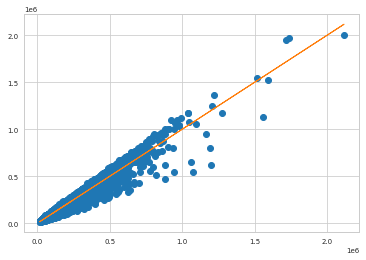

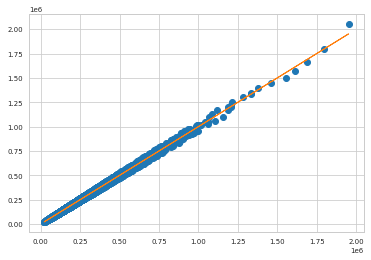

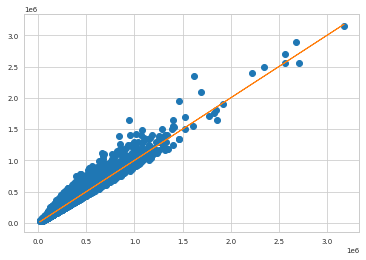

In [186]:
df = symptoms_dataframe_ri.copy()

for i in range(3):
    print(i)
    y_trainR_temp = y_trainR[np.where(y_train == i)[0]]
    X_trainR_temp = X_trainR[np.where(y_train == i)[0],:]
    
    y_testR_temp = y_testR[np.where(y_test == i)[0]]
    X_testR_temp = X_testR[np.where(y_test == i)[0],:]    
    
    predictions_testR = modelRegression[i].predict(X_testR_temp)
    predictions_trainR = modelRegression[i].predict(X_trainR_temp)

    avmValue_test = df['avmValue'].values[train_samples:][np.where(y_test == i)[0]]
    avmValue_train = df['avmValue'].values[:train_samples][np.where(y_train == i)[0]]
    
    predictions_test_valueR = avmValue_test/(1-predictions_testR)
    predictions_train_valueR = avmValue_train/(1-predictions_trainR)
    
    print('') 
    fig = plt.figure()
    plt.plot(predictions_test_valueR, 
         df['Transprice'].values[train_samples:][np.where(y_test == i)[0]],'o')
    plt.plot(predictions_test_valueR,predictions_test_valueR)
    
    print('') 
    print('Testing')
    print(np.mean(np.abs(df['Transprice'].values[train_samples:][np.where(y_test == i)[0]]-predictions_test_valueR)/\
              (df['Transprice'].values[train_samples:][np.where(y_test == i)[0]])))
    print(np.mean(np.abs(df['Transprice'].values[train_samples:][np.where(y_test == i)[0]] - avmValue_test)/\
                  (df['Transprice'].values[train_samples:][np.where(y_test == i)[0]])))
    
    print('') 
    print('Training') 
    print(np.mean(np.abs(df['Transprice'].values[:train_samples][np.where(y_train == i)[0]]-predictions_train_valueR)/\
              (df['Transprice'].values[:train_samples][np.where(y_train == i)[0]])))
    print(np.mean(np.abs(df['Transprice'].values[:train_samples][np.where(y_train == i)[0]] - avmValue_train)/\
                  (df['Transprice'].values[:train_samples][np.where(y_train == i)[0]])))    

In [ ]:
fig = plt.figure(figsize=(12,10))
importances = model.feature_importances_
indices = np.argsort(importances)
features = predictor_columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)
features = predictor_columns


In [ ]:
list(features[indices][-250:])

In [ ]:
[features[i] for i in indices]